# DM-44574 : run stack/ing on WET-001 data 


# DM-42718: run WEP with S/N code on WET-001 data


This requires a run that also calculates variance. 




In [391]:
base_output_dir = '/sdf/data/rubin/shared/scichris/DM-43524_grid/wfs_grid4/'
butler_root_path = os.path.join(base_output_dir, "imsimData")
butler_inst_name = "Cam"
seq_num = 1000
num_pro = 10 
pipeline_yaml_path = '/sdf/data/rubin/shared/scichris/DM-43524_grid/lsstPipelineCustomDoVar.yaml'
pipe_cmd = f"pipetask run -b {butler_root_path} "\
f"-i refcats,LSST{butler_inst_name}/raw/all,LSST{butler_inst_name}/calib/unbounded "\
f"--instrument lsst.obs.lsst.Lsst{butler_inst_name} "\
f"--register-dataset-types --output-run ts_imsim_{seq_num}_var -p {pipeline_yaml_path} -d "\
f'"visit.seq_num IN ({seq_num})" -j {num_pro}'
print(pipe_cmd)

pipetask run -b /sdf/data/rubin/shared/scichris/DM-43524_grid/wfs_grid4/imsimData -i refcats,LSSTCam/raw/all,LSSTCam/calib/unbounded --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run ts_imsim_1000_var -p /sdf/data/rubin/shared/scichris/DM-43524_grid/lsstPipelineCustomDoVar.yaml -d "visit.seq_num IN (1000)" -j 10


The file `lsstPipelineCustomDoVar.yaml`  runs the ISR with variance, WEP with wcs task with mag selection. That's too much.  Split so that we first run ISR with variance, and then WEP. 

    cd  /sdf/group/rubin/shared/scichris/DM-42718_WET-006
    cp /sdf/data/rubin/shared/scichris/DM-43524_grid/lsstPipelineCustomDoVar.yaml .
    
    
    
    # This yaml file is used to define the tasks and configuration of
    # a Gen 3 pipeline used for testing in ts_wep.
    description: wep basic processing test pipeline
    # Here we specify the corresponding instrument for the data we
    # will be using.
    instrument: lsst.obs.lsst.LsstCam
    # Then we can specify each task in our pipeline by a name
    # and then specify the class name corresponding to that task
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        # Below we specify the configuration settings we want to use
        # when running the task in this pipeline. Since our data doesn't
        # include bias or flats we only want to use doApplyGains and
        # doOverscan in our isr task.
        config:
          connections.outputExposure: 'postISRCCD'
          doBias: False
          doVariance: True
          doLinearize: False
          doCrosstalk: False
          doDefect: False
          doNanMasking: False
          doInterpolate: False
          doBrighterFatter: False
          doDark: False
          doFlat: False
          doApplyGains: True
          doFringe: False
          doOverscan: True
          python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN'
      generateDonutCatalogWcsTask:
        class: lsst.ts.wep.task.generateDonutCatalogWcsTask.GenerateDonutCatalogWcsTask
        config:
          donutSelector.useCustomMagLimit: True
      cutOutDonutsCwfsTask:
        class: lsst.ts.wep.task.cutOutDonutsCwfsTask.CutOutDonutsCwfsTask
      calcZernikesTask:
        class: lsst.ts.wep.task.calcZernikesTask.CalcZernikesTask
        config:
          python: |
            from lsst.ts.wep.task import EstimateZernikesTieTask, EstimateZernikesDanishTask
            config.estimateZernikes.retarget(EstimateZernikesTieTask)

Test the query:

In [392]:
registry = dafButler.Butler('/sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo').registry
datasetRefs = registry.queryDatasets('raw',collections=['LSSTCam/raw/all'],
                                     where=f"instrument='LSSTCam' and exposure.seq_num in (2002)").expanded()
print(len(list(datasetRefs)))

8


Test run:


    pipetask run -b /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo -i LSSTCam/raw/all,LSSTCam/calib/unbounded --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run run1_ISR_only_2005_test_var -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineISRdoVar.yaml -j 5 -d "exposure.seq_num in (2005)"


I get 

    No dataset artifact found for raw@{instrument: 'LSSTCam', detector: 195, exposure: 5024072302005, band: 'r', physical_filter: 'r_57'} [sc=Exposure] (run=LSSTCam/raw/all id=c1768e83-fa52-5999-b7e4-3b8cc2b20434)

How is that possible? 

    butler query-datasets --collections LSSTCam/raw/all  --where "instrument='LSSTCam' and exposure.seq_num = 2001" /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo   raw --show-uri


Shows that they seem to have been ingested...


Trying out  the solution of remaking the symlinks:

https://lsstc.slack.com/archives/C01FBUGM2CV/p1706749998094219?thread_ts=1706732724.635549&cid=C01FBUGM2CV 

    ln -s /sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001/state_1/* /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo/LSSTCam/raw/all/raw/20240723/IM_P_20240723_002001/

     ln -s /sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001/state_2/* /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo/LSSTCam/raw/all/raw/20240723/IM_P_20240723_002002/

      ln -s /sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001/state_3/* /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo/LSSTCam/raw/all/raw/20240723/IM_P_20240723_002003/

       ln -s /sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001/state_4/* /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo/LSSTCam/raw/all/raw/20240723/IM_P_20240723_002004/

     ln -s /sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001/state_5/* /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo/LSSTCam/raw/all/raw/20240723/IM_P_20240723_002005/








## Try making new repository newRepo from the scratch : 

In [393]:
import os
path_cwd = '/sdf/group/rubin/shared/scichris/DM-42718_WET-006'
butlerRootPath = os.path.join(path_cwd, 'newRepo')
cmd1 = f"butler create {butlerRootPath}"
print(cmd1)

butler create /sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo


In [394]:
butlerInstName = 'Cam'
cmd = f"butler register-instrument {butlerRootPath} lsst.obs.lsst.Lsst{butlerInstName}"
print(cmd)

cmd = f"butler write-curated-calibrations {butlerRootPath} lsst.obs.lsst.Lsst{butlerInstName}"
print(cmd)

butler register-instrument /sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo lsst.obs.lsst.LsstCam
butler write-curated-calibrations /sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo lsst.obs.lsst.LsstCam


In [395]:
outputImgDir = '/sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001_lsstcam/state_*'
cmd = f"butler ingest-raws {butlerRootPath} {outputImgDir}/amp*"
print(cmd)

butler ingest-raws /sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo /sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001_lsstcam/state_*/amp*


    butler define-visits /sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo   lsst.obs.lsst.LsstCam

Test ISR

    pipetask run -b /sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo -i LSSTCam/raw/all,LSSTCam/calib/unbounded --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run run1_ISR_only_2005_test_var -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineISRdoVar.yaml -j 5 -d "exposure.seq_num in (2005)"


Run ISR for all:


    pipetask run -b /sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo -i LSSTCam/raw/all,LSSTCam/calib/unbounded --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run run1_ISR_only_var -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineISRdoVar.yaml -j 5



Test if the dataset is there: 

In [396]:
from lsst.daf import butler as dafButler
butlerRootPath = '/sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo'
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
runName = 'run1_ISR_only_2005_test_var'
datasetRefs = registry.queryDatasets('postISRCCD',collections=[runName],
                                     where=f"instrument='LSSTCam' ").expanded()
             # where=f"instrument='LSST{butlerInstName}' and detector in (199) ").expanded()
print(len(list(datasetRefs)))


8


In [397]:
from lsst.daf import butler as dafButler
butlerRootPath = '/sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo'
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
registry.queryCollections()

['LSSTCam/calib',
 'LSSTCam/calib/unbounded',
 'LSSTCam/calib/curated/19700101T000000Z',
 'LSSTCam/raw/all',
 'run1_ISR_only_2005_test_var',
 'state_5_det191_192_WEP_direct_test/20240529T010326Z',
 'state_5_det191_192_WEP_direct_test/20240529T010426Z',
 'state_5_WEP_direct_test/20240603T205858Z',
 'run_isr_all/20240604T233944Z',
 'refcats/gaia_dr2_20200414',
 'all_states_WEP_direct/20240605T204621Z',
 'state_5_det191_192_WEP_direct_test',
 'state_5_WEP_direct_test',
 'run_isr_all',
 'refcats',
 'all_states_WEP_direct']

In [398]:
from lsst.daf import butler as dafButler
butlerRootPath = '/sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo'
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
runName = 'run_isr_all'
datasetRefs = registry.queryDatasets('postISRCCD',collections=[runName],
                                     where=f"instrument='LSSTCam' ").expanded()
             # where=f"instrument='LSST{butlerInstName}' and detector in (199) ").expanded()
print(len(list(datasetRefs)))


800


So indeed all states got ISRd -  there are 8 CCDs for 100 states, total 800 images. 

In [399]:
# Run ISR for all; this would be run on lsst-devl 

# DONE   2024 / 06 / 04  


print('allocateNodes.py -v -n 10 -c 64 -m 60:00:00 -q roma,milano -g 1800 s3df --account rubin:commissioning')

runName = 'run_isr_all'
numPro=50
pipelineYamlPath = os.path.join(path_cwd, "lsstPipelineISRdoVar.yaml")

cmd = f"pipetask run -b {butlerRootPath} "\
      f"-i LSST{butlerInstName}/raw/all,LSST{butlerInstName}/calib/unbounded "\
      f"--instrument lsst.obs.lsst.Lsst{butlerInstName} "\
      f"--register-dataset-types --output-run {runName}  -p {pipelineYamlPath} -j {numPro}"
print('\n\n')
print(cmd)
#runProgram(cmd)
cmd = f"bps submit site_bps.yaml  -b {butlerRootPath} "\
      f"-i LSST{butlerInstName}/raw/all,LSST{butlerInstName}/calib/unbounded "\
      f' -o {runName}  -p {pipelineYamlPath} '

print('\n\n\n', cmd)


allocateNodes.py -v -n 10 -c 64 -m 60:00:00 -q roma,milano -g 1800 s3df --account rubin:commissioning



pipetask run -b /sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo -i LSSTCam/raw/all,LSSTCam/calib/unbounded --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run run_isr_all  -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineISRdoVar.yaml -j 50



 bps submit site_bps.yaml  -b /sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo -i LSSTCam/raw/all,LSSTCam/calib/unbounded  -o run_isr_all  -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineISRdoVar.yaml 


 bps report --id 11197057.0

## NEXT 

**In the meantime**: ingest the GAIA dataset to be able to run WEP as WCS-based:

    DONE   butler register-dataset-type /sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo gaia_dr2_20200414 SimpleCatalog htm7
    
    DONE   butler ingest-files -t direct /sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo gaia_dr2_20200414 refcats/gaia_dr2_20200414  /sdf/group/rubin/datasets/refcats/htm/v1/gaia_dr2_20200414.ecsv --prefix /sdf/group/rubin
    
    DONE   butler collection-chain /sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo --mode extend refcats refcats/gaia_dr2_20200414


**In the meantime**: run WEP as direct detect since it doesn't require any refcat: 

    generateDonutDirectDetectTask:
        class: lsst.ts.wep.task.generateDonutDirectDetectTask.GenerateDonutDirectDetectTask
        config:
          donutSelector.useCustomMagLimit: True
    cutOutDonutsCwfsTask:
        class: lsst.ts.wep.task.cutOutDonutsCwfsTask.CutOutDonutsCwfsTask
    calcZernikesTask:
        class: lsst.ts.wep.task.calcZernikesTask.CalcZernikesTask
        config:
          python: |
            from lsst.ts.wep.task import EstimateZernikesTieTask, EstimateZernikesDanishTask
            config.estimateZernikes.retarget(EstimateZernikesTieTask)




lsstPipelineWEPdirect_new.yaml 
            

Test1:  Run just one state / detector pair  with direct detect : 

In [400]:
path_to_butler = '/sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo'

isr_collection = 'run1_ISR_only_2005_test_var'
output_collection = 'state_5_det191_192_WEP_direct_test'
path_to_yaml = '/sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineWEPdirect_new.yaml'

dataQuery = "detector in (191,192) and exposure.seq_num in (2005)"

cmd = f'pipetask run -b  {path_to_butler} -i {isr_collection},LSSTCam/calib/unbounded  -o {output_collection}  -p {path_to_yaml} -d "{dataQuery}" --register-dataset-types'
print('\n\n\n', cmd)







 pipetask run -b  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo -i run1_ISR_only_2005_test_var,LSSTCam/calib/unbounded  -o state_5_det191_192_WEP_direct_test  -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineWEPdirect_new.yaml -d "detector in (191,192) and exposure.seq_num in (2005)" --register-dataset-types


Test2:  Run just one state  with all 4 corners with direct detect  : 

In [401]:
path_to_butler = '/sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo'

isr_collection = 'run1_ISR_only_2005_test_var'
output_collection = 'state_5_WEP_direct_test'
path_to_yaml = '/sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineWEPdirect_new.yaml'

dataQuery = " exposure.seq_num in (2005)"

cmd = f'pipetask run -b  {path_to_butler} -i {isr_collection},LSSTCam/calib/unbounded  -o {output_collection}  -p {path_to_yaml} -d "{dataQuery}" --register-dataset-types'
print('\n\n\n', cmd)







 pipetask run -b  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo -i run1_ISR_only_2005_test_var,LSSTCam/calib/unbounded  -o state_5_WEP_direct_test  -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineWEPdirect_new.yaml -d " exposure.seq_num in (2005)" --register-dataset-types


Test 3:  run all ISRd with that direct detect with bps:   

    allocateNodes.py -v -n 10 -c 64 -m 60:00:00 -q roma,milano -g 1800 s3df --account rubin:commissioning

    bps submit site_bps.yaml  -b /sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo -i run_isr_all,LSSTCam/calib/unbounded  -o all_states_WEP_direct  -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineWEPdirect_new.yaml 


check that the data products exist:

In [402]:

butlerRootPath = '/sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo'
runName = output_collection
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
output_collection = 'all_states_WEP_direct'
datasetRefs = registry.queryDatasets('donutStampsExtra', collections=[output_collection],
                                     where=f"instrument='LSSTCam' and detector.purpose='WAVEFRONT' ").expanded()
             # where=f"instrument='LSST{butlerInstName}' and detector in (199) ").expanded()
print(len(list(datasetRefs)))
refs = []
for ref in datasetRefs:
    refs.append(ref)
print(len(refs))
#for ref in refs:
#    print(ref.dataId)
    

400
400


Ok, since there's one`donutStampsExtra` per two half-sensors, all are done. 

## Next : 

* Run all states with  direct detect 

* Run all states with WCS 



Test if the data products exist:

In [403]:

butlerRootPath = '/sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo'
runName = output_collection
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry

datasetRefs = registry.queryDatasets('donutStampsExtra', collections=[output_collection],
                                     where=f"instrument='LSSTCam' and detector.purpose='WAVEFRONT' ").expanded()
             # where=f"instrument='LSST{butlerInstName}' and detector in (199) ").expanded()
print(len(list(datasetRefs)))
refs = []
for ref in datasetRefs:
    refs.append(ref)
for ref in refs:
    print(ref.dataId)
    

400
{instrument: 'LSSTCam', detector: 191, visit: 5024072302001, band: 'r', day_obs: 20240723, physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 191, visit: 5024072302002, band: 'r', day_obs: 20240723, physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 191, visit: 5024072302003, band: 'r', day_obs: 20240723, physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 191, visit: 5024072302004, band: 'r', day_obs: 20240723, physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 191, visit: 5024072302005, band: 'r', day_obs: 20240723, physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 191, visit: 5024072302006, band: 'r', day_obs: 20240723, physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 191, visit: 5024072302007, band: 'r', day_obs: 20240723, physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 191, visit: 5024072302008, band: 'r', day_obs: 20240723, physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 191, visit: 5024072302009, band: '

In [404]:
butlerIsr = dafButler.Butler(butlerRootPath)
datasetRefs = registry.queryDatasets('postISRCCD', collections=['run1_ISR_only_2005_test_var'],
                                     where=f"instrument='LSSTCam' and detector.purpose='WAVEFRONT' ").expanded()
#refs = []
#for ref in datasetRefs:
#    refs.append(ref)

In [405]:
exp_extra = butlerIsr.get('postISRCCD',  dataId={'instrument': 'LSSTCam', 
                                                 'detector': 191, 
                                                 'exposure': 5024072302005,},
                          collections=['run1_ISR_only_2005_test_var']
                     
                    )
exp_intra = butlerIsr.get('postISRCCD',  dataId={'instrument': 'LSSTCam', 
                                                 'detector': 192, 
                                                 'exposure': 5024072302005},
                          collections=['run1_ISR_only_2005_test_var']
                    )


In [406]:
exp_extra.detector.getName()


'R00_SW0'

In [407]:
exp_intra.detector.getName()


'R00_SW1'

check if the orientation of image attached do `stamp_im.image.array` is the same as to`wep_im.image`... ? It would be the same for all donuts in a given sensor: 

In [408]:
refs[0].dataId.detector.raft

'R00'

Load  all stamps from all corners: 

In [409]:
output_collection = 'state_5_WEP_direct_test'

butlerRootPath = '/sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo'
runName = output_collection
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry

datasetRefs = registry.queryDatasets('donutStampsExtra', collections=[output_collection],
                                     where=f"instrument='LSSTCam' and detector.purpose='WAVEFRONT' ").expanded()
             # where=f"instrument='LSST{butlerInstName}' and detector in (199) ").expanded()
print(len(list(datasetRefs)))
refs = []
for ref in datasetRefs:
    refs.append(ref)
    print(ref.dataId)


stamps = {}
for ref in refs: 
    stamps[ref.dataId.detector.raft]= {}
    
    stampsExtra = butler.get('donutStampsExtra', 
                      dataId=ref.dataId, 
                      collections=[output_collection]
                    )
    stampsIntra = butler.get('donutStampsIntra', 
                      dataId=ref.dataId, 
                      collections=[output_collection]
                    )
    stamps[ref.dataId.detector.raft]['donutStampsExtra'] = stampsExtra
    stamps[ref.dataId.detector.raft]['donutStampsIntra'] = stampsIntra

4
{instrument: 'LSSTCam', detector: 191, visit: 5024072302005, band: 'r', day_obs: 20240723, physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 195, visit: 5024072302005, band: 'r', day_obs: 20240723, physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 199, visit: 5024072302005, band: 'r', day_obs: 20240723, physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 203, visit: 5024072302005, band: 'r', day_obs: 20240723, physical_filter: 'r_57'}


Plot just one stamp per corner using both the `stamp_im` and `wep_im`:

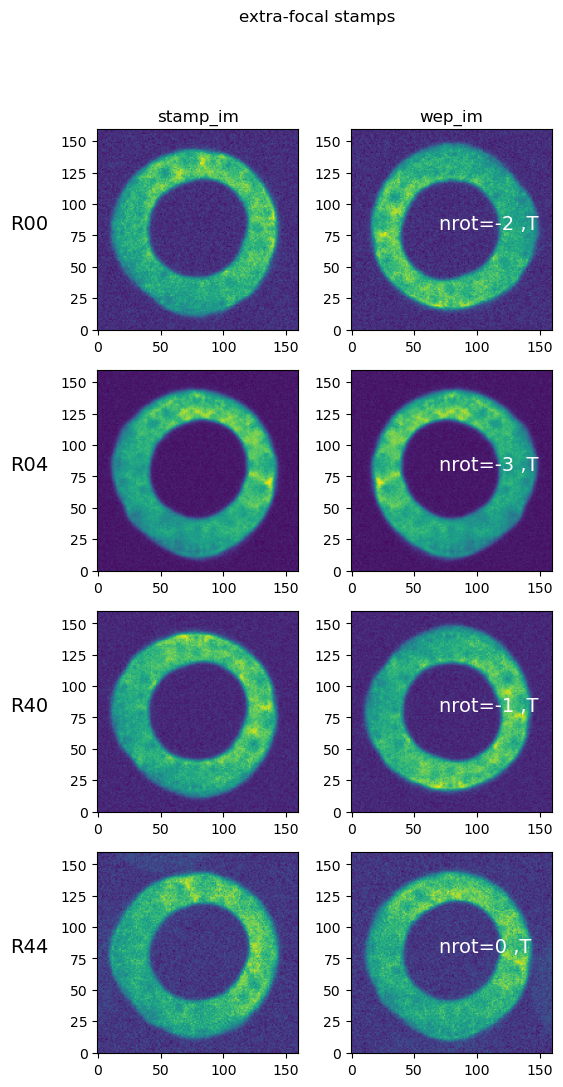

In [410]:
from lsst.ts.wep.utils import getCameraFromButlerName
camera = getCameraFromButlerName('LSSTCam')

fig, axs = plt.subplots(4,2, figsize=(6,12))

fig.suptitle('extra-focal stamps')
axs[0,0].set_title('stamp_im')
axs[0,1].set_title('wep_im')
row  =0 
for raft in stamps.keys():
    stamp = stamps[raft]['donutStampsExtra'][3]
    detector = camera.get(stamp.detector_name)
    eulerZ = -detector.getOrientation().getYaw().asDegrees()
    nRot = int(eulerZ // 90)
    axs[row,0].imshow(stamp.stamp_im.image.array, origin='lower')
    axs[row,1].imshow(stamp.wep_im.image, origin='lower')
    axs[row,0].text(-70,80, raft, fontsize=14)
    axs[row,1].text(70,80, f'nrot={nRot} ,T', fontsize=14, color='white')
    row += 1 


Plot these in the same arrangement as the four corners to show that they are correctly being rotated to one coordinate system:

In [411]:
# The wavefront sensors will do the rotation as following, based on the Euler angle.

#    R04                 R44
# O-------           ----------O        /\ +y (CCS)
# |  SW1 |           |    |    |        |
# |------|           |SW0 | SW1|        |
# |  SW0 |           |    |    |        |
# -------O           O----------        _
#                                   +z (.) -----> +x
#      R00                  R40
# ------------O          O-------
# |     |     |          |  SW0 |
# | SW1 | SW0 |          |------|
# |     |     |          |  SW1 |
# O------------          -------O

In [412]:
rafts = ['R04', 'R44', 'R00','R40']

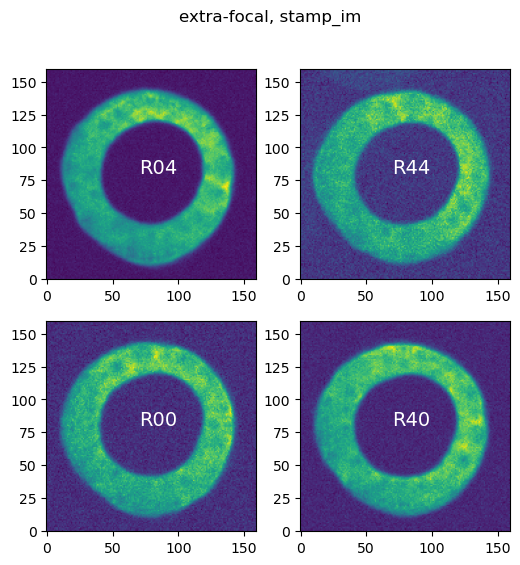

In [413]:
from lsst.ts.wep.utils import getCameraFromButlerName
camera = getCameraFromButlerName('LSSTCam')

fig, axs = plt.subplots(2,2, figsize=(6,6))

fig.suptitle('extra-focal, stamp_im')
#axs[0,0].set_title('stamp_im')
#axs[0,1].set_title('wep_im')
#row  =0 
i=0
ax = np.ravel(axs)
for raft in rafts:#stamps.keys():
    stamp = stamps[raft]['donutStampsExtra'][3]
    detector = camera.get(stamp.detector_name)
    eulerZ = -detector.getOrientation().getYaw().asDegrees()
    nRot = int(eulerZ // 90)
    ax[i].imshow(stamp.stamp_im.image.array, origin='lower')
   #$ ax[i].imshow(stamp.wep_im.image, origin='lower')
    ax[i].text(70,80, raft, fontsize=14, color='white')
    #ax[i].text(70,80, f'nrot={nRot} ,T', fontsize=14, color='white')
    i += 1 


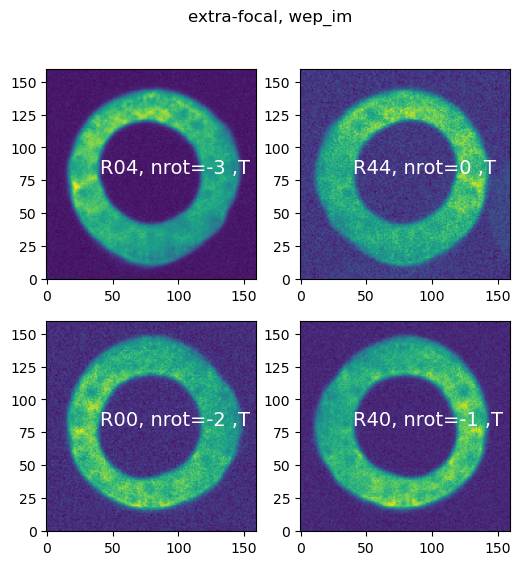

In [414]:
from lsst.ts.wep.utils import getCameraFromButlerName
camera = getCameraFromButlerName('LSSTCam')

fig, axs = plt.subplots(2,2, figsize=(6,6))

fig.suptitle('extra-focal, wep_im')
#axs[0,0].set_title('stamp_im')
#axs[0,1].set_title('wep_im')
#row  =0 
i=0
ax = np.ravel(axs)
for raft in rafts:#stamps.keys():
    stamp = stamps[raft]['donutStampsExtra'][3]
    detector = camera.get(stamp.detector_name)
    eulerZ = -detector.getOrientation().getYaw().asDegrees()
    nRot = int(eulerZ // 90)
    #ax[i].imshow(stamp.stamp_im.image.array, origin='lower')
    ax[i].imshow(stamp.wep_im.image, origin='lower')
    #ax[i].text(70,80, raft, fontsize=14, color='white')
    ax[i].text(40,80, f'{raft}, nrot={nRot} ,T', fontsize=14, color='white')
    i += 1 


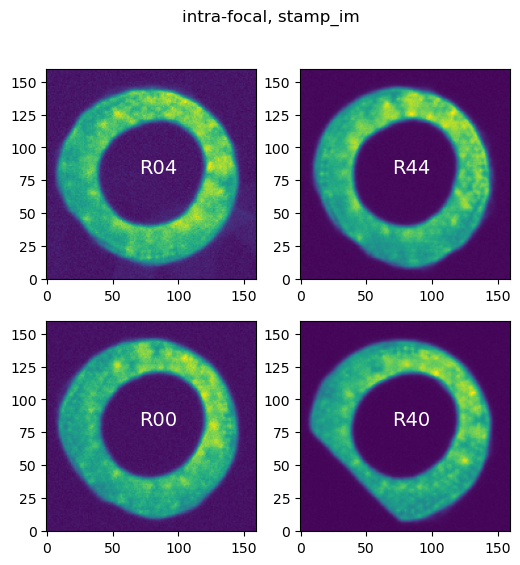

In [415]:
from lsst.ts.wep.utils import getCameraFromButlerName
camera = getCameraFromButlerName('LSSTCam')

fig, axs = plt.subplots(2,2, figsize=(6,6))

fig.suptitle('intra-focal, stamp_im')
#axs[0,0].set_title('stamp_im')
#axs[0,1].set_title('wep_im')
#row  =0 
i=0
ax = np.ravel(axs)
for raft in rafts:#stamps.keys():
    stamp = stamps[raft]['donutStampsIntra'][1]
    detector = camera.get(stamp.detector_name)
    eulerZ = -detector.getOrientation().getYaw().asDegrees()
    nRot = int(eulerZ // 90)
    ax[i].imshow(stamp.stamp_im.image.array, origin='lower')
   #$ ax[i].imshow(stamp.wep_im.image, origin='lower')
    ax[i].text(70,80, raft, fontsize=14, color='white')
    #ax[i].text(70,80, f'nrot={nRot} ,T', fontsize=14, color='white')
    i += 1 


In [416]:
from lsst.ts.wep.utils import getCameraFromButlerName
camera = getCameraFromButlerName('LSSTCam')

fig, axs = plt.subplots(2,2, figsize=(6,6))

fig.suptitle('intra-focal, wep_im')
#axs[0,0].set_title('stamp_im')
#axs[0,1].set_title('wep_im')
#row  =0 
i=0
ax = np.ravel(axs)
for raft in rafts:#stamps.keys():
    stamp = stamps[raft]['donutStampsIntra'][1]
    detector = camera.get(stamp.detector_name)
    eulerZ = -detector.getOrientation().getYaw().asDegrees()
    nRot = int(eulerZ // 90)
    #ax[i].imshow(stamp.stamp_im.image.array, origin='lower')
    ax[i].imshow(stamp.wep_im.image, origin='lower')
    #ax[i].text(70,80, raft, fontsize=14, color='white')
    ax[i].text(40,80, f'{raft}, nrot={nRot} ,T', fontsize=14, color='white')
    i += 1 


Error in callback <function flush_figures at 0x7fc4aab96fc0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Given the plethora of rotations, it would be best to create a stacked `wep_im` because that's actually used later in the wavefront estimation. 

The `stamp.calcFieldXY`  is transposed in  `stamp.wep_im.fieldAngle` in https://github.com/lsst-ts/ts_wep/blob/559416be1aaec3ed8fa92d6c759a1f26d0bec938/python/lsst/ts/wep/task/donutStamp.py#L258C8-L260C52 

     # Get the field angle, and transpose (DVCS -> CCS)
      fieldAngle = self.calcFieldXY()
      fieldAngle = (fieldAngle[1], fieldAngle[0])



In [417]:
stamp.calcFieldXY()

(-1.2670950506048158, 1.2553518928464829)

In [418]:
stamp.wep_im.fieldAngle

array([ 1.25535189, -1.26709505])

That's how the rotation is obtained in `setWepImage`:

    detector = camera.get(self.detector_name)

    # Get the rotation with respect to the science sensors
    eulerZ = -detector.getOrientation().getYaw().asDegrees()
    nRot = int(eulerZ // 90)

In [419]:
stamp.detector_name

'R40_SW1'

In [420]:
detector = camera.get(stamp.detector_name)

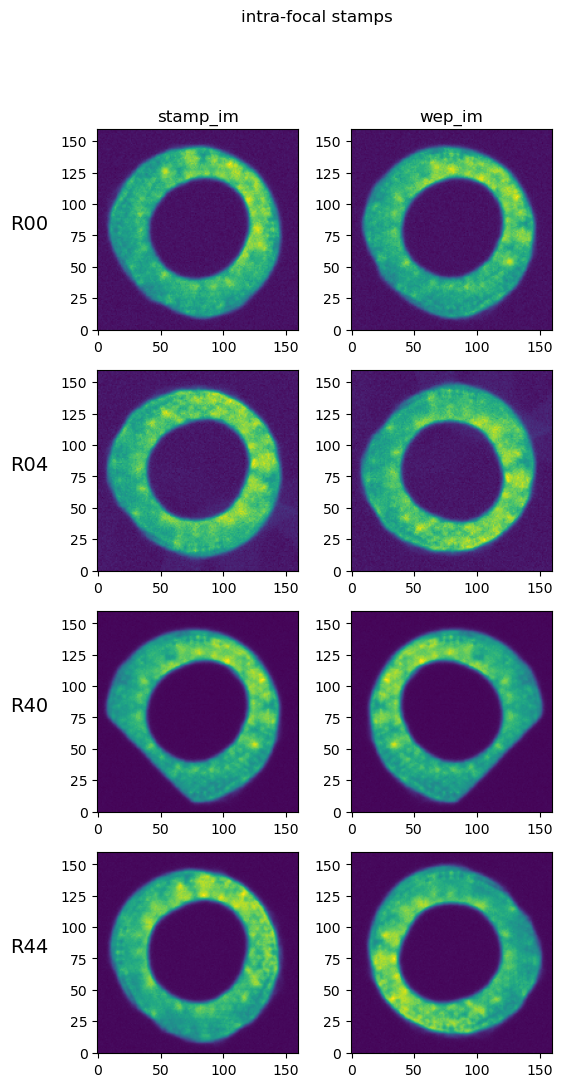

In [421]:
fig, axs = plt.subplots(4,2, figsize=(6,12))

fig.suptitle('intra-focal stamps')
axs[0,0].set_title('stamp_im')
axs[0,1].set_title('wep_im')
row  =0 
for raft in stamps.keys():
    stamp = stamps[raft]['donutStampsIntra'][1]
    axs[row,0].imshow(stamp.stamp_im.image.array, origin='lower')
    axs[row,1].imshow(stamp.wep_im.image, origin='lower')
    axs[row,0].text(-70,80, raft, fontsize=14)
    row += 1 

In [422]:
list(stampsExtra.metadata)

['SIMPLE',
 'BITPIX',
 'NAXIS',
 'EXTEND',
 'COMMENT',
 'RA_DEG',
 'DEC_DEG',
 'DET_NAME',
 'CAM_NAME',
 'DFC_TYPE',
 'DFC_DIST',
 'MAG',
 'CENT_X0',
 'CENT_Y0',
 'CENT_X',
 'CENT_Y',
 'CENT_DR',
 'BLEND_CX',
 'BLEND_CY',
 'X0',
 'Y0',
 'SN',
 'SIGNAL_MEAN',
 'SIGNAL_SUM',
 'NPX_MASK',
 'BKGD_STDEV',
 'SQRT_MEAN_VAR',
 'BKGD_VAR',
 'BACKGROUND_IMAGE_MEAN',
 'NOISE_VAR_BKGD',
 'NOISE_VAR_DONUT',
 'EFFECTIVE',
 'ENTROPY',
 'PEAK_HEIGHT',
 'BANDPASS',
 'HAS_MASK',
 'HAS_VARIANCE',
 'HAS_ARCHIVE',
 'N_STAMPS',
 'STAMPCLS',
 'VERSION',
 'ARCHIVE_IDS']

In [423]:
stampsExtra.metadata.getArray('SN')

[1195.68811035156,
 1028.31018066406,
 973.465698242188,
 812.3681640625,
 489.817596435547,
 381.191619873047,
 426.907684326172,
 435.146026611328,
 382.796844482422,
 380.162384033203]

In [424]:
registry.queryDatasetTypes()

[DatasetType('camera', {instrument}, Camera, isCalibration=True),
 DatasetType('transmission_sensor', {instrument, detector}, TransmissionCurve, isCalibration=True),
 DatasetType('raw', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure),
 DatasetType('isr_config', {}, Config),
 DatasetType('isr_log', {band, instrument, day_obs, detector, group, physical_filter, exposure}, ButlerLogRecords),
 DatasetType('isr_metadata', {band, instrument, day_obs, detector, group, physical_filter, exposure}, TaskMetadata),
 DatasetType('postISRCCD', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure),
 DatasetType('packages', {}, Packages),
 DatasetType('calcZernikesTask_config', {}, Config),
 DatasetType('cutOutDonutsCwfsTask_config', {}, Config),
 DatasetType('generateDonutDirectDetectTask_config', {}, Config),
 DatasetType('donutCatalog', {band, instrument, day_obs, detector, physical_filter, visit}, DataFrame),
 DatasetType('generateDonu

In [425]:
donutsExtraQuality = butler.get('donutsExtraQuality', 
                      dataId=refs[0].dataId, 
                      collections=[output_collection]
                    )


In [426]:
donutsExtraQuality

SN   ENTROPY  ENTROPY_SELECT  SN_SELECT  FINAL_SELECT
0   4022.150146  1.813928            True       True          True
1   2858.577393  2.342391            True       True          True
2   1737.956787  3.146256            True       True          True
3    950.696411  3.828440            True       True          True
4    875.796387  3.872346            True       True          True
5    862.921753  3.895814            True       True          True
6    607.319824  4.245328            True       True          True
7    608.335205  4.246622            True       True          True
8    518.340942  4.311699            True       True          True
9    504.865326  4.423969            True       True          True
10   417.016479  4.778825            True       True          True
11   425.637543  4.563924            True       True          True

In [427]:
zks = butler.get('zernikeEstimateRaw', 
                      dataId=refs[0].dataId, 
                      collections=[output_collection]
                    )


In [428]:
#zks

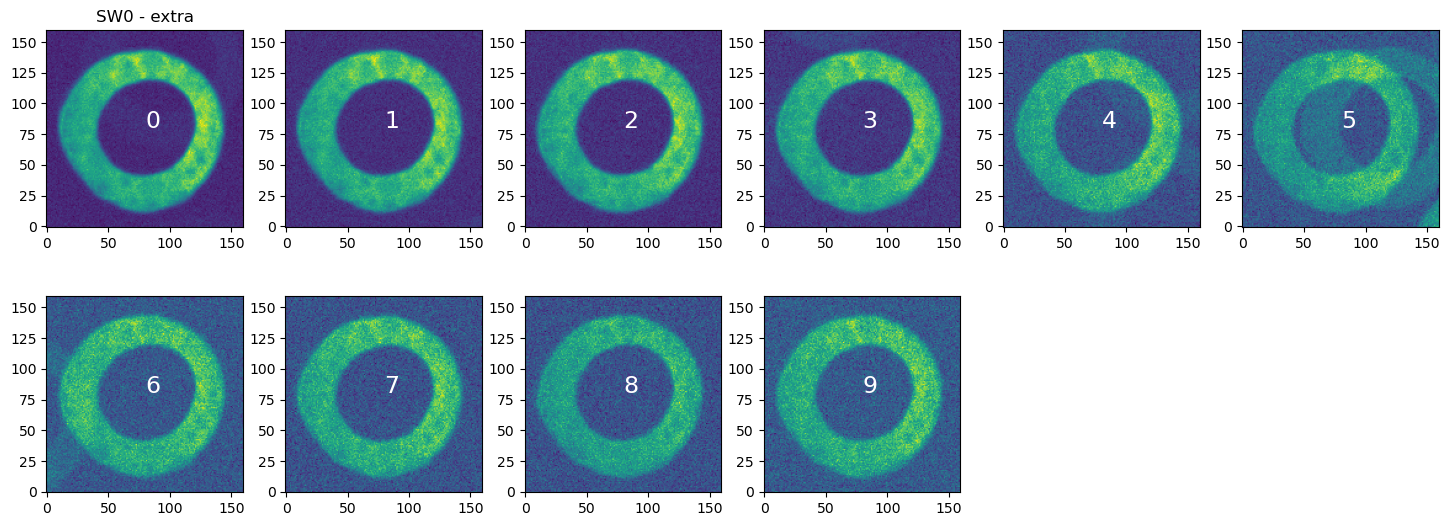

In [429]:
import matplotlib.pyplot as plt 
import numpy as np 

def plot_donut_stamps(donut_stamps, text=''):
    """Plot the donut stamp image cutouts.

    Parameters
    ----------
    donut_stamps: Collection of postage stamps as
        lsst.afw.image.maskedImage.MaskedImage.
        with additional metadata.
    """
    # calculate number of rows given
    # the constraint of the number of
    # columns
    n_donuts = len(donut_stamps)
    ncols = 6
    nrows = n_donuts // ncols
    if nrows * ncols < n_donuts:
        nrows += 1

    fig, axs = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3 * nrows))
    ax = np.ravel(axs)
    for i in range(n_donuts):
        donut = donut_stamps[i]
        ax[i].imshow(donut.stamp_im.image.array, origin="lower")
        ax[i].text(80, 80, f"{i}", fontsize=17, c="white")
    fig.subplots_adjust(hspace=0.35)

    # if there are more axes than donuts,
    # turn off the extra axes
    ncells = nrows * ncols
    if ncells > n_donuts:
        for axis in ax[n_donuts:]:
            axis.axis("off")
    ax[0].set_title(text)
    return
    
plot_donut_stamps(stampsExtra, text='SW0 - extra')

In [430]:
exp_extra.detector.getName()

'R00_SW0'

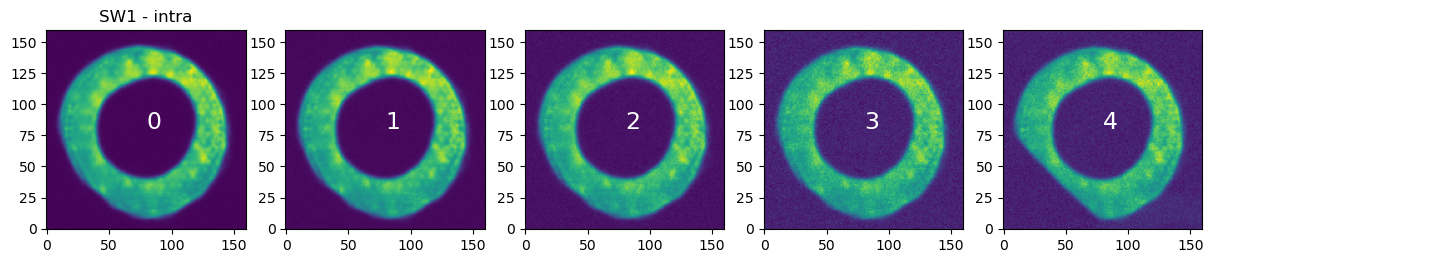

In [431]:
plot_donut_stamps(stampsIntra, text='SW1 - intra')

In [432]:
exp_intra.detector.getName()

'R00_SW1'

For stacking all these donut stamps would need to rewrite the code after the refactoring, but it would actually be easier rather than otherwise. Multiplying the image by mask removes the background, but which mask to use? Perhaps just the one attached to each donut so that we're simply removing the background .... 

Extra-focal:

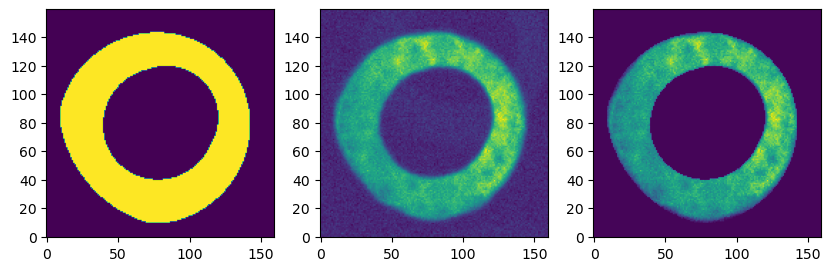

In [433]:
fig,ax = plt.subplots(1,3,figsize=(10,4))
mask = stampsExtra[0].stamp_im.mask.array
image = stampsExtra[0].stamp_im.image.array

ax[0].imshow(mask, origin='lower')
ax[1].imshow(image, origin='lower')
ax[2].imshow(mask*image, origin='lower')

IndexError: list index out of range

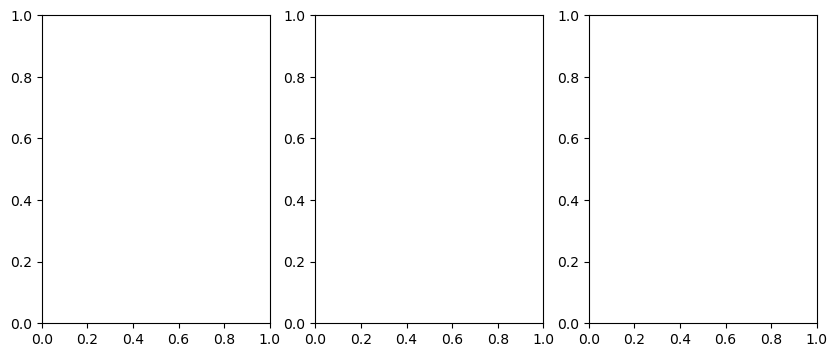

In [434]:
fig,ax = plt.subplots(1,3,figsize=(10,4))
mask = stampsIntra[5].stamp_im.mask.array
image = stampsIntra[5].stamp_im.image.array
binary_mask = np.array(mask>0).astype(int)
ax[0].imshow(binary_mask, origin='lower')
ax[1].imshow(image, origin='lower')
ax[2].imshow(binary_mask*image, origin='lower')

In [ ]:
plt.imshow(stampsIntra[5].stamp_im.image.array, origin='lower')

In [ ]:
plt.imshow(stampsIntra[5].wep_im.image, origin='lower')

## Refactor stacking code:

In [ ]:
Read the stamps here 

In [ ]:
output_collection = 'state_5_WEP_direct_test'

butlerRootPath = '/sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo'
runName = output_collection
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry

datasetRefs = registry.queryDatasets('donutStampsExtra', collections=[output_collection],
                                     where=f"instrument='LSSTCam' and detector.purpose='WAVEFRONT' ").expanded()
             # where=f"instrument='LSST{butlerInstName}' and detector in (199) ").expanded()
print(len(list(datasetRefs)))
refs = []
for ref in datasetRefs:
    refs.append(ref)
    print(ref.dataId)


stamps = {}
for ref in refs: 
    stamps[ref.dataId.detector.raft]= {}
    
    stampsExtra = butler.get('donutStampsExtra', 
                      dataId=ref.dataId, 
                      collections=[output_collection]
                    )
    stampsIntra = butler.get('donutStampsIntra', 
                      dataId=ref.dataId, 
                      collections=[output_collection]
                    )
    stamps[ref.dataId.detector.raft]['donutStampsExtra'] = stampsExtra
    stamps[ref.dataId.detector.raft]['donutStampsIntra'] = stampsIntra

In [ ]:
image[80:120, 80:120]

In [ ]:
mask[80:120, 80:120]

In [ ]:
binary_mask = np.array(mask>0).astype(int)

In [ ]:
np.shape(binary_mask)

In [ ]:
np.array(image*binary_mask)[80:120, 80:120]

In [ ]:
np.array(image*mask)[80:120, 80:120]

In [ ]:
plt.hist(np.ravel(image))

In [ ]:
np.unique(mask)

In [ ]:
plt.hist(np.ravel(image*binary_mask))

In [ ]:
plt.hist(np.ravel(image[mask>0]))

In [ ]:
def stack_donuts_refactor(donutStamps,  N =2,  indices = None, pixel_stack = 'mean' ,
                     use_mask = False):
    
    # first , ensure we have that many donuts to stack ... 
    # assuming we stack the same number of extra-focal donuts and intra-focal donuts 
    # we could also stack just donuts on one side of focus,
    # but then we would have uneven depth (much deeper intra-image vs extra-image... )
    
    stacked = {}
    
    Ntotal = len(donutStamps)
    
    if indices is None:
        indices = np.arange(N)
        
    else:
        N = len(indices)
        
    stacked['N'] = N
    stacked['indices'] = indices
        
    # create updated donut stamps consisting of the stacked images
    
    # initialize empty arrays of the correct dimension
    shape = np.shape(donutStamps[0].stamp_im.image.array)
    donutStackedArray = np.zeros(shape)
    
    # add donut image arrays, store the x,y 
    xs = []
    ys = []
    
    stacked_arrays = np.zeros(shape=(N,shape[0],shape[0]))
    j = 0 
    for i in indices:
        #print(f'stacking {i}')
        stamp = donutStamps[i]
        image = stamp.stamp_im.image.array
        if use_mask:
            mask = stamp.stamp_im.mask.array  # has values like 0, 1024,  2048 etc 
            binary_mask = np.array(mask>0).astype(int)  # has values 0 or 1 
            arr = image * binary_mask
        else:
            arr = image
        
        stacked_arrays[j] = arr

        fieldxy = stamp.calcFieldXY()[::-1]
        xs.append(fieldxy[0])
        ys.append(fieldxy[1])
        
        j += 1 
    
    
    #print('stacked: ', indices)
    # store the original fieldXY 
    stacked['fieldX'] = xs
    stacked['fieldY'] = ys
        
    # store the stacked image
    if pixel_stack == 'sum':
        donutStackedArray = np.sum(stacked_arrays, axis=0)
    elif pixel_stack == 'mean':
        donutStackedArray = np.mean(stacked_arrays, axis=0)
    elif pixel_stack == 'nanmean':
        donutStackedArray = np.nanmean(stacked_arrays, axis=0)
        
    stacked['donutStackedArray'] = donutStackedArray
    
    # find the midpoint fieldXY coordinates
    # average in the same way x and y coordinates 
    # for the intra and extra donut alike
    # treat them as already transposed
    stacked['fieldXmean'] = np.mean(xs)
    stacked['fieldYmean'] = np.mean(ys)
    
    # store information on how pixels were combined 
    stacked['pixelStack'] = pixel_stack

    return stacked

In [ ]:
use_mask=False

fig,ax = plt.subplots(3,4,figsize=(16,12))

row = 0
for method in ['sum', 'mean', 'nanmean'
                   ]:
  
    stacked_extra = stack_donuts_refactor(stampsExtra, N = len(stampsExtra),
                                    pixel_stack=method, use_mask=use_mask)   
    stacked_intra = stack_donuts_refactor(stampsIntra, N = len(stampsIntra),
                                    pixel_stack=method, use_mask=use_mask)     

    ax[row,0].plot(stacked_intra['donutStackedArray'][100,:])
    ax[row,1].plot(stacked_extra['donutStackedArray'][100,:])
    ax[row,2].imshow(stacked_intra['donutStackedArray'], origin='lower')
    ax[row,3].imshow(stacked_extra['donutStackedArray'], origin='lower')
    ax[row,0].set_title(f'Intra, pixel {method}')
    ax[row,1].set_title(f'Extra, pixel {method}')
    ax[row,2].set_title(f'Intra, pixel {method}')
    ax[row,3].set_title(f'Extra, pixel {method}')
    ax[row,0].set_ylabel('counts')
    row += 1 

fig.suptitle(f'{exp_extra.detector.getName()}, {exp_intra.detector.getName()} no mask', fontsize=16)

In [ ]:
use_mask=True

fig,ax = plt.subplots(3,4,figsize=(16,12))

row = 0
for method in ['sum', 'mean', 'nanmean'
                   ]:
  
    stacked_extra = stack_donuts_refactor(stampsExtra, N = len(stampsExtra),
                                    pixel_stack=method, use_mask=use_mask)   
    stacked_intra = stack_donuts_refactor(stampsIntra, N = len(stampsIntra),
                                    pixel_stack=method, use_mask=use_mask)     

    ax[row,0].plot(stacked_intra['donutStackedArray'][100,:])
    ax[row,1].plot(stacked_extra['donutStackedArray'][100,:])
    ax[row,2].imshow(stacked_intra['donutStackedArray'], origin='lower')
    ax[row,3].imshow(stacked_extra['donutStackedArray'], origin='lower')
    ax[row,0].set_title(f'Intra, pixel {method}')
    ax[row,1].set_title(f'Extra, pixel {method}')
    ax[row,2].set_title(f'Intra, pixel {method}')
    ax[row,3].set_title(f'Extra, pixel {method}')
    ax[row,0].set_ylabel('counts')
    row += 1 

fig.suptitle(f'{exp_extra.detector.getName()}, {exp_intra.detector.getName()} use mask', fontsize=16)

Given that we can stack per sensor,  try running WEP - what needs to be done after the refactor?  

The part of `calcZernikesTask` that passes just the stamps is : 

    zkCoeffRaw = self.estimateZernikes.run(
            donutStampsExtraSelect, donutStampsIntraSelect
        )
 



In [ ]:
from lsst.ts.wep.task import (
    CalcZernikesTask,
    CalcZernikesTaskConfig
)
config = CalcZernikesTaskConfig()
calcTask = CalcZernikesTask(config=config, name="Base Task")


Make new combined stamps. Try to edit as little as possible... Originally `cutOutDonutsBase` makes


    donutStamp = DonutStamp(
                stamp_im=finalStamp,
                sky_position=lsst.geom.SpherePoint(
                    donutRow["coord_ra"],
                    donutRow["coord_dec"],
                    lsst.geom.radians,
                ),
                centroid_position=centroid_position,
                blend_centroid_positions=blendCentroidPositions,
                detector_name=detectorName,
                cam_name=cameraName,
                defocal_type=defocalType.value,
                # Save defocal offset in mm.
                defocal_distance=instrument.defocalOffset * 1e3,
                bandpass=bandLabel,
                archive_element=linear_wcs,
                    )


and then declares all metadata, and then collects the  individual `DonutStamp` stored in temporary `finalStamops`as 

    DonutStamps(finalStamps, metadata=stampsMetadata, use_archive=True)


Try to only modify part of a given stamp, given that most of the information would not need to be changed... 

Otherwise would need to dig into `calcZernikes` =-> `estimateZernikes`  --< `wfEstimator` to  be able to access any given algorithm directly.


In [ ]:
stacked_extra['donutStackedArray']

In [ ]:
stampExtra.calcFieldXY()

In [ ]:
stamp.sky_position

One way of creating a combined donut stamp:


    combStamp =  DonutStamp(
                    stamp_im=stacked_extra['donutStackedArray'],
                    sky_position=lsst.geom.SpherePoint(
                        donutRow["coord_ra"],
                        donutRow["coord_dec"],
                        lsst.geom.radians,
                    ),
                    centroid_position=centroid_position,
                    blend_centroid_positions=blendCentroidPositions,
                    detector_name=detectorName,
                    cam_name=cameraName,
                    defocal_type=defocalType.value,
                    # Save defocal offset in mm.
                    defocal_distance=instrument.defocalOffset * 1e3,
                    bandpass=bandLabel,
                    archive_element=linear_wcs,
                        )




In [ ]:
from lsst.ts.wep.task.donutStamp import DonutStamp
from lsst.ts.wep.task.donutStamps import DonutStamps

import lsst.geom
#stacked_extra
  

In [ ]:
#combinedStamp = DonutStamps(stamps,

In [ ]:
#stamps.metadata

In [ ]:
#combinedStamp = stamps

In [ ]:
#calcTask.run(stamps[0], stampsIntra[0]
#        )

But otherwise,  could perhaps not have to do that?  

In [ ]:
donutStampsExtra = stampsExtra

In [ ]:
donutStampsIntra = stampsIntra

In [ ]:
from lsst.ts.wep.estimation import WfAlgorithm, WfAlgorithmFactory, WfEstimator


# part of estimateZernikesBase.run method
# Get the instrument
camName = donutStampsExtra[0].cam_name
detectorName = donutStampsExtra[0].detector_name

In [ ]:
from lsst.ts.wep.utils import (
    WfAlgorithmName,
    convertHistoryToMetadata,
    getTaskInstrument,
)

In [ ]:
#getTaskInstrument?

In [ ]:
instrument = getTaskInstrument(
    camName,
    detectorName,
    None,
    #self.config.instConfigFile,
    
)

In [ ]:
from lsst.ts.wep.task.estimateZernikesTieTask import EstimateZernikesTieConfig
from lsst.ts.wep.task.estimateZernikesBase import EstimateZernikesBaseConfig

In [ ]:
estimateZkTieConfig = EstimateZernikesTieConfig()
estimateZernikesBaseConfig = EstimateZernikesBaseConfig()

In [ ]:
wfAlgoName = WfAlgorithmName.TIE

In [ ]:
algoConfig = {
            key: val
            for key, val in estimateZkTieConfig.toDict().items()
            if key not in estimateZernikesBaseConfig._fields.keys()
        }
wfAlgoConfig = WfAlgorithmFactory.createWfAlgorithm(wfAlgoName, algoConfig)
    

In [ ]:
wfAlgoConfig

In [ ]:
estimateZernikesBaseConfig.return4Up

In [ ]:
# Create the wavefront estimator
wfEst = WfEstimator(
    algoName=wfAlgoName,
    algoConfig=wfAlgoConfig,
    instConfig=instrument,
    jmax=estimateZernikesBaseConfig.maxNollIndex,
    startWithIntrinsic=estimateZernikesBaseConfig.startWithIntrinsic,
    returnWfDev=estimateZernikesBaseConfig.returnWfDev,
    return4Up=estimateZernikesBaseConfig.return4Up,
    units=estimateZernikesBaseConfig.units,
    saveHistory=estimateZernikesBaseConfig.saveHistory,
)

In [ ]:
donutExtra = stampsExtra[0]
donutIntra = stampsIntra[0]

In [ ]:
defocalOffset = np.mean(
    [
        donutExtra.defocal_distance,
        donutIntra.defocal_distance,
    ]
)

what's needed to actualy run the estimation is an object called `wep_image`; it's ordinarily set in `DonutStamp`, but if we need to combine several stamps,  we'd need to essentially make a new `wep_image`:. A method of `donutStamp` called `_setWepImage` does the following:

    def _setWepImage(self):
        """Return a ts.wep.image.Image object for the stamp.

        Note that the information from the butler is in the data visualization
        coordinate system (DVCS), but the WEP Image is in the global camera
        coordinate system (CCS). These coordinate systems are related by a
        transpose. See sitcomtn-003.lsst.io for more information.

        Furthermore, CWFS images that arrive from the butler are rotated with
        respect to the science sensors. The info in the WEP Images has been
        de-rotated so that everything aligns with the global coordinate system
        used by the science sensors.

        Returns
        -------
        ts.wep.image.Image

        Raises
        ------
        RuntimeError
            If the rotation angle of the detector with respect to the science
            sensors is not an integer multiple of 90 degrees.
        """
        # Get the camera and detector
        camera = self.getCamera()
        detector = camera.get(self.detector_name)

        # Get the rotation with respect to the science sensors
        eulerZ = -detector.getOrientation().getYaw().asDegrees()
        nRot = int(eulerZ // 90)
        if not np.isclose(eulerZ % 90, 0):
            raise RuntimeError(
                f"The detector is rotated {-eulerZ} deg with respect to the science "
                "sensors, but _setWepImage() only works for sensors whose rotations "
                "are an integer multiple of 90 deg."
            )

        # Rotate to orientation of science sensors
        image = np.rot90(self.stamp_im.getImage().getArray(), nRot)

        # Transpose the image (DVCS -> CCS)
        image = image.T

        # Get the field angle, and transpose (DVCS -> CCS)
        fieldAngle = self.calcFieldXY()
        fieldAngle = (fieldAngle[1], fieldAngle[0])

        # Determine the blend offsets
        if self.blend_centroid_positions.size > 0:
            # Get the offsets in the original pixel coordinates
            blendOffsets = self.blend_centroid_positions - self.centroid_position

            # Rotate the coordinates (by -90 each time)
            # to match the science sensors
            rotMat = np.array([[0, 1], [-1, 0]])
            if self.defocal_type == "extra":
                rotMat = np.linalg.matrix_power(rotMat, nRot + 2)
            else:
                rotMat = np.linalg.matrix_power(rotMat, nRot)
            blendOffsets = np.transpose(rotMat @ blendOffsets.T)

        else:
            blendOffsets = None

        # Package everything in an Image object
        wepImage = Image(
            image=image,
            fieldAngle=fieldAngle,
            defocalType=self.defocal_type,
            bandLabel=self.bandpass,
            blendOffsets=blendOffsets,
        )

        self.wep_im = wepImage


individual donuts already have their images in the correct orientation (creating a `wep_im` is part of making a `DonutStamp`, so this all happens when donuts are cut out in `cutoutDonutsBase`: 

In [ ]:
stampsExtra[0].wep_im.image

In [ ]:
stampsExtra[0].wep_im.fieldAngle

In [ ]:
stampsExtra[0].wep_im.blendOffsets

In [ ]:
wepImage = Image(
            image=image,
            fieldAngle=fieldAngle,
            defocalType=self.defocal_type,
            bandLabel=self.bandpass,
            blendOffsets=blendOffsets,
        )

In [ ]:
wfEst.instrument.defocalOffset = defocalOffset / 1e3  # m -> mm

# Estimate Zernikes
zk = wfEst.estimateZk(donutExtra.wep_im, donutIntra.wep_im)

In [ ]:
# the `wep_im` contains all that `wfEst` needs to estimate zks...

# so:

#donutExtra.wep_im?

In [ ]:
#donutExtra.wep_im.image

Lets construct a stacked `wep_im`:

In [ ]:
stamp.detector_name

In [ ]:
from lsst.ts.wep.utils import getCameraFromButlerName
from lsst.ts.wep.image import Image

def stack_donut_wep_im_refactor(donutStamps,  N =2,  indices = None, pixel_stack = 'mean' ,
                     use_mask = False, replace_zeros_with_nans = True ):
    
    # first , ensure we have that many donuts to stack ... 
    # assuming we stack the same number of extra-focal donuts and intra-focal donuts 
    # we could also stack just donuts on one side of focus,
    # but then we would have uneven depth (much deeper intra-image vs extra-image... )
    
    stacked = {}
    
    if indices is None:
        indices = np.arange(N)
        
    else:
        N = len(indices)
        
    stacked['N'] = N
    stacked['indices'] = indices
        
    # create updated donut stamps consisting of the stacked images
    
    # initialize empty arrays of the correct dimension
    shape = np.shape(donutStamps[0].stamp_im.image.array)
    stacked_arrays = np.zeros(shape=(N,shape[0],shape[0]))
    
    # add donut image arrays, store the x,y 
    xs = []
    ys = []
    
   
    j = 0 
    for i in indices:
        #print(f'stacking {i}')
        stamp = donutStamps[i]
        image = stamp.stamp_im.image.array
        if use_mask:
            mask = stamp.stamp_im.mask.array  # has values like 0, 1024,  2048 etc 
            binary_mask = np.array(mask>0).astype(int)  # has values 0 or 1 
            arr = image * binary_mask
            if replace_zeros_with_nans:
                arr[arr==0] = np.nan  # replace zeros with NaNs 
        else:
            arr = image
        
        stacked_arrays[j] = arr

        # that already transposes each field angle ... 
        fieldxy = stamp.calcFieldXY()[::-1]
        xs.append(fieldxy[0])
        ys.append(fieldxy[1])
        
        j += 1 
    
    
        #print('stacked: ', indices)
        # store the original fieldXY 
        stacked['fieldX'] = xs
        stacked['fieldY'] = ys
        
    # store the stacked image
    if pixel_stack == 'sum':
        donutStackedArray = np.sum(stacked_arrays, axis=0)
    elif pixel_stack == 'mean':
        donutStackedArray = np.mean(stacked_arrays, axis=0)
    elif pixel_stack == 'nanmean':
        donutStackedArray = np.nanmean(stacked_arrays, axis=0)
        
    stacked['donutStackedArray'] = donutStackedArray
    
    # find the midpoint fieldXY coordinates
    # average in the same way x and y coordinates 
    # for the intra and extra donut alike
    # treat them as already transposed
    stacked['fieldXmean'] = np.mean(xs)
    stacked['fieldYmean'] = np.mean(ys)
    
    # store information on how pixels were combined 
    stacked['pixelStack'] = pixel_stack


    # part of _setWepImage(self):
    """Return a ts.wep.image.Image object for the stamp.

    Note that the information from the butler is in the data visualization
    coordinate system (DVCS), but the WEP Image is in the global camera
    coordinate system (CCS). These coordinate systems are related by a
    transpose. See sitcomtn-003.lsst.io for more information.

    Furthermore, CWFS images that arrive from the butler are rotated with
    respect to the science sensors. The info in the WEP Images has been
    de-rotated so that everything aligns with the global coordinate system
    used by the science sensors.
    """
    # both the camera name and the detector would be all
    # identical for all stamps in here ,
    # hence it would be the same Euler angle 
    
    # stamp.cam_name  yields eg. LSSTCam;
    # taking it from the stamp 
    # allows to stack also images from LSSTComCam,  or FAM ... 
    camera = getCameraFromButlerName(stamp.cam_name)
     
    detector = camera.get(stamp.detector_name)

    # Get the rotation with respect to the science sensors
    eulerZ = -detector.getOrientation().getYaw().asDegrees()
    nRot = int(eulerZ // 90)
    if not np.isclose(eulerZ % 90, 0):
        raise RuntimeError(
            f"The detector is rotated {-eulerZ} deg with respect to the science "
            "sensors, but _setWepImage() only works for sensors whose rotations "
            "are an integer multiple of 90 deg."
        )

    # Rotate to orientation of science sensors
    image = np.rot90(donutStackedArray, nRot)

    # Transpose the image (DVCS -> CCS)
    image = image.T

    # Get the field angle, and transpose (DVCS -> CCS)
    #fieldAngle = stamp.calcFieldXY()
    # the x,y are already a transpose of calcFieldXY()
    fieldAngle = (stacked['fieldXmean'], stacked['fieldYmean'])

    # Determine the blend offsets
    if stamp.blend_centroid_positions.size > 0:
        # Get the offsets in the original pixel coordinates
        blendOffsets = stamp.blend_centroid_positions - stamp.centroid_position

        # Rotate the coordinates (by -90 each time)
        # to match the science sensors
        rotMat = np.array([[0, 1], [-1, 0]])
        if stamp.defocal_type == "extra":
            rotMat = np.linalg.matrix_power(rotMat, nRot + 2)
        else:
            rotMat = np.linalg.matrix_power(rotMat, nRot)
        blendOffsets = np.transpose(rotMat @ blendOffsets.T)

    else:
        blendOffsets = None

    # Package everything in an Image object
    wepImage = Image(
        image=image,
        fieldAngle=fieldAngle,
        defocalType=stamp.defocal_type,
        bandLabel=stamp.bandpass,
        blendOffsets=blendOffsets,
    )

    stacked['wep_im'] = wepImage


    

    return stacked

In [ ]:
len(donutStamps)

In [ ]:
stacked_arrays = []
for stamp in donutStamps:
    image = stamp.stamp_im.image.array
    mask = stamp.stamp_im.mask.array  # has values like 0, 1024,  2048 etc 
    binary_mask = np.array(mask>0).astype(int)  # has values 0 or 1 
    arr = image * binary_mask
    arr[arr==0] = np.nan  # set the array to be nan wherever it would be 0 before ...

    stacked_arrays.append(arr)
    

In [ ]:
np.shape(stacked_arrays[0])


In [ ]:
plt.imshow(np.nanmean(stacked_arrays, axis=0))

In [ ]:
    for i in indices:
        #print(f'stacking {i}')
        stamp = donutStamps[i]
        image = stamp.stamp_im.image.array
        if use_mask:
            mask = stamp.stamp_im.mask.array  # has values like 0, 1024,  2048 etc 
            binary_mask = np.array(mask>0).astype(int)  # has values 0 or 1 
            arr = image * binary_mask
            arr[arr==0] = np.nan  # replace zeros with NaNs 
        else:
            arr = image
        
        stacked_arrays[j] = arr

        # that already transposes each field angle ... 
        fieldxy = stamp.calcFieldXY()[::-1]
        xs.append(fieldxy[0])
        ys.append(fieldxy[1])
        
        j += 1 
    
    
        #print('stacked: ', indices)
        # store the original fieldXY 
        stacked['fieldX'] = xs
        stacked['fieldY'] = ys
        
    # store the stacked image
    if pixel_stack == 'sum':
        donutStackedArray = np.sum(stacked_arrays, axis=0)
    elif pixel_stack == 'mean':
        donutStackedArray = np.mean(stacked_arrays, axis=0)
    elif pixel_stack == 'nanmean':
        donutStackedArray = np.nanmean(stacked_arrays, axis=0)

In [ ]:
plt.imshow(arr, origin='lower')

In [ ]:
 stamp.calcFieldXY()[::-1]

In [ ]:
 stamp.calcFieldXY()

In [ ]:
stamp.wep_im.fieldAngle

In [ ]:
rafts

In [ ]:
fig,ax = plt.subplots(4,2,figsize=(4,8))
row = 0 
ax[0,0].set_title('image')
ax[0,1].set_title('wep_im')
for raft in stamps.keys():
    donutStamps = stamps[raft]['donutStampsExtra']
    stacked = stack_donut_wep_im_refactor(donutStamps,  N =len(donutStamps), 
                                          pixel_stack = 'nanmean', use_mask = True)
    ax[row,0].imshow(stacked['donutStackedArray'], origin='lower')
    ax[row,1].imshow(stacked['wep_im'].image, origin='lower')
    ax[row,0].text(-95,80, raft, fontsize=14)
    row+=1

In [ ]:
rafts

In [ ]:
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()


In [ ]:
fig,axs = plt.subplots(2,2,figsize=(6,6))
ax = np.ravel(axs)
#row = 0 
fig.suptitle('stacked extra wep_im')
#ax[0,0].set_title('image')
#ax[0,1].set_title('wep_im')
i=0
for raft in rafts :
    donutStamps = stamps[raft]['donutStampsExtra']
    stacked = stack_donut_wep_im_refactor(donutStamps,  N =len(donutStamps), 
                                          pixel_stack = 'nanmean', use_mask = True)
    vmin,vmax = zscale.get_limits(stacked['wep_im'].image)
    #$ax[row,0].imshow(stacked['donutStackedArray'], origin='lower')
    ax[i].imshow(stacked['wep_im'].image, origin='lower', vmin=vmin,vmax=vmax)
    ax[i].text(80,80, raft, fontsize=14, color='k')
    i+=1

In [ ]:
fig,ax = plt.subplots(4,2,figsize=(4,8))
row = 0 
ax[0,0].set_title('image')
ax[0,1].set_title('wep_im')
for raft in stamps.keys():
    donutStamps = stamps[raft]['donutStampsIntra']
    stacked = stack_donut_wep_im_refactor(donutStamps,  N =len(donutStamps), 
                                          pixel_stack = 'nanmean', use_mask = True)
    ax[row,0].imshow(stacked['donutStackedArray'], origin='lower')
    ax[row,1].imshow(stacked['wep_im'].image, origin='lower')
    ax[row,0].text(-95,80, raft, fontsize=14)
    row+=1

In [ ]:
stacked['wep_im']

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(6,6))
ax = np.ravel(axs)
#row = 0 
fig.suptitle('stacked intra wep_im')
#ax[0,0].set_title('image')
#ax[0,1].set_title('wep_im')
i=0
for raft in rafts :
    donutStamps = stamps[raft]['donutStampsIntra']
    stacked = stack_donut_wep_im_refactor(donutStamps,  N =len(donutStamps), 
                                          pixel_stack = 'nanmean', use_mask = True)
    #$ax[row,0].imshow(stacked['donutStackedArray'], origin='lower')
    ax[i].imshow(stacked['wep_im'].image, origin='lower')
    ax[i].text(80,80, raft, fontsize=14, color='k')
    i+=1

In [ ]:
stacked

Try fitting the stacked `wep_im` : what's needed ?  Do self-contained test:

In [ ]:
s

In [ ]:
stamps['R00']

In [ ]:
results =  {}

from lsst.ts.wep.task.estimateZernikesTieTask import EstimateZernikesTieConfig
from lsst.ts.wep.task.estimateZernikesBase import EstimateZernikesBaseConfig

from lsst.ts.wep.utils import (
    WfAlgorithmName,
    convertHistoryToMetadata,
    getTaskInstrument,
)

for raft in rafts:
    results[raft] = {}
    
    stampsExtra = stamps[raft]['donutStampsExtra']
    stampsIntra = stamps[raft]['donutStampsIntra']
    camName = stampsExtra[0].cam_name
    detectorName = stampsExtra[0].detector_name
    
    instrument = getTaskInstrument(
        camName,
        detectorName,
        None,
        #self.config.instConfigFile,
        
    )
    
    
    
    estimateZkTieConfig = EstimateZernikesTieConfig()
    estimateZernikesBaseConfig = EstimateZernikesBaseConfig()
    
    
    wfAlgoName = WfAlgorithmName.TIE
    
    algoConfig = {
                key: val
                for key, val in estimateZkTieConfig.toDict().items()
                if key not in estimateZernikesBaseConfig._fields.keys()
            }
    wfAlgoConfig = WfAlgorithmFactory.createWfAlgorithm(wfAlgoName, algoConfig)
        
    
    # Create the wavefront estimator
    wfEst = WfEstimator(
        algoName=wfAlgoName,
        algoConfig=wfAlgoConfig,
        instConfig=instrument,
        jmax=estimateZernikesBaseConfig.maxNollIndex,
        startWithIntrinsic=estimateZernikesBaseConfig.startWithIntrinsic,
        returnWfDev=estimateZernikesBaseConfig.returnWfDev,
        return4Up=estimateZernikesBaseConfig.return4Up,
        units=estimateZernikesBaseConfig.units,
        saveHistory=estimateZernikesBaseConfig.saveHistory,
    )
    
    
    donutExtra = stampsExtra[0]
    donutIntra = stampsIntra[0]
    # the mean defocal offset would be the same for all considered donuts 
    defocalOffset = np.mean(
        [
            donutExtra.defocal_distance,
            donutIntra.defocal_distance,
        ]
    )
    print(raft, defocalOffset) 
    wfEst.instrument.defocalOffset = defocalOffset / 1e3  # m -> mm
    
    # Estimate Zernikes
    results[raft]['raw_zk'] = []
    for i in range(min(len(stampsExtra), len(stampsIntra))):
        donutExtra = stampsExtra[i]
        donutIntra = stampsIntra[i]
        zk = wfEst.estimateZk(donutExtra.wep_im, donutIntra.wep_im)
        results[raft]['raw_zk'].append(zk)
    
    
    # stack donuts and estimate as well 
    stackedExtra = stack_donut_wep_im_refactor(stampsExtra,  N =len(stampsExtra), 
                                              pixel_stack = 'nanmean', use_mask = True)
    
    
    stackedIntra = stack_donut_wep_im_refactor(stampsIntra,  N =len(stampsIntra), 
                                              pixel_stack = 'nanmean', use_mask = True)
    
    zkst = wfEst.estimateZk(stackedExtra['wep_im'], stackedIntra['wep_im'])
    results[raft]['stacked_zk'] = zkst
    

np.save('results_state005_nanmean_old',results)

In [ ]:
results_0 =  np.load('results_state005_nanmean_old.npy', allow_pickle=True).item() # keeping the non-masked as 0
results_1 = np.load('results_state005_nanmean.npy', allow_pickle=True).item() ## setting non-masked as nans 

In [ ]:
np.sum(np.array(results_1[raft]['raw_zk']) - np.array(results_0[raft]['raw_zk']))

In [ ]:
results_0[raft]['raw_zk']

In [ ]:
raft

In [ ]:
raft = 'R00'
stampsExtra = stamps[raft]['donutStampsExtra']
stampsIntra = stamps[raft]['donutStampsIntra']

plot_donut_stamps(stampsIntra, text=f'{raft} SW1 - intra')
plot_donut_stamps(stampsExtra, text=f'{raft} SW0 - extra')

In [ ]:
raft = 'R00'
fig,ax = plt.subplots(2,2)



fig.suptitle(raft)

col=0
ax[0,col].set_title('Replace 0s with NaNs')
stackedExtra = stack_donut_wep_im_refactor(stampsExtra,  N =len(stampsExtra), 
                                          pixel_stack = 'nanmean', use_mask = True)


stackedIntra = stack_donut_wep_im_refactor(stampsIntra,  N =len(stampsIntra), 
                                          pixel_stack = 'nanmean', use_mask = True)
ax[0,col].imshow(stackedIntra['donutStackedArray'], origin='lower')
ax[1,col].imshow(stackedExtra['donutStackedArray'], origin='lower')

col=1
ax[0,col].set_title('Keep 0s')
stackedExtra = stack_donut_wep_im_refactor(stampsExtra,  N =len(stampsExtra), 
                                          pixel_stack = 'nanmean', use_mask = True,
                                          replace_zeros_with_nans=False)


stackedIntra = stack_donut_wep_im_refactor(stampsIntra,  N =len(stampsIntra), 
                                          pixel_stack = 'nanmean', use_mask = True,
                                          replace_zeros_with_nans=False)
ax[0,col].imshow(stackedIntra['donutStackedArray'], origin='lower')
ax[1,col].imshow(stackedExtra['donutStackedArray'], origin='lower')

In [ ]:
# this checks that whatever were the raw zk results, they are bitwise identical, since 
# exactly the same  donuts were used ...
assert np.sum(np.array(results_1[raft]['raw_zk']) - np.array(results_0[raft]['raw_zk'])) == 0

# this plots the two sets of  results  
for raft in rafts:
    fig,ax = plt.subplots(1,1,figsize=(8,4))
    ax.set_title(raft + ' nanmean')
    for results,col,ls, label in zip([results_0, results_1], ['blue' , 'green'], ['--','-.'],
                                    ['keep zeros', 'replace as nans']):
        ax.plot(np.arange(4,23), results[raft]['stacked_zk'], label=f'stacked {label}')
    # plot raw zks from only one set of stacking results 
    raw_zks = results[raft]['raw_zk'] 
    for i in range(len(raw_zks)):
            ax.plot(np.arange(4,23), raw_zks[i],alpha=0.4 , 
                    c='grey', label='raw')
    ax.legend(bbox_to_anchor=[1.0,0.8])
    ax.set_ylabel('Zk mode [microns]')
    ax.set_xlabel('Zk mode')
    ax.set_xticks([4,6,8,10,12,14,16,18,20,22])

Just double check that these raw zks are the same as what was fitted by the pipeline:

In [ ]:
output_collection = 'state_5_WEP_direct_test'
butlerRootPath = '/sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo'
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry

datasetRefs = registry.queryDatasets('zernikeEstimateRaw', collections=[output_collection],
                                     where=f"instrument='LSSTCam' and detector.purpose='WAVEFRONT' ").expanded()
             # where=f"instrument='LSST{butlerInstName}' and detector in (199) ").expanded()
print(len(list(datasetRefs)))




In [ ]:
ref.dataId.detector.raft

In [ ]:
zks = {}

refs = []
for ref in datasetRefs:
    refs.append(ref)
    print(ref.dataId)
    zk = butler.get('zernikeEstimateRaw', 
                      dataId=ref.dataId, 
                      collections=[output_collection]
                    )
    zks[ref.dataId.detector.raft] =  zk

The difference between pipeline fit (`calcZernikesTask` that followed automated call of `generateDonutsDirectDetect`  show that it is to within  a floating point error:

In [ ]:
 

for raft in rafts:
    fig,ax = plt.subplots(1,1,figsize=(8,4))
    ax.set_title(raft + ' nanmean')

    
    pair_zks = results[raft]['raw_zk'] 

    pipe_zks = zks[raft]

    for i in range(len(pair_zks)):
        #print(pair_zks[i]  - pipe_zks[i])
        diff = pair_zks[i]  - pipe_zks[i]
        ax.plot(np.arange(4,23), diff,alpha=0.4 , 
                    c='grey', label=f'diff {i}')

    ax.axhline(0)
    ax.legend()#bbox_to_anchor=[1.0,0.8])
    ax.set_ylabel('Zk mode [microns]')
    ax.set_xlabel('Zk mode')
    ax.set_xticks([4,6,8,10,12,14,16,18,20,22])

In [ ]:
# this checks that whatever were the raw zk results, they are bitwise identical, since 
# exactly the same  donuts were used ...
assert np.sum(np.array(results_1[raft]['raw_zk']) - np.array(results_0[raft]['raw_zk'])) == 0

for raft in rafts:
    fig,ax = plt.subplots(1,1,figsize=(8,4))
    ax.set_title(raft + ' nanmean')
    #for results,col,ls, label in zip([results_0, results_1], ['blue' , 'green'], ['--','-.'],
    #                                ['keep zeros', 'replace as nans']):
    #    ax.plot(np.arange(4,23), results[raft]['stacked_zk'], label=f'stacked {label}')
    # plot raw zks from only one set of stacking results 
    raw_zks = results[raft]['raw_zk'] 
    for i in range(len(raw_zks)):
            ax.plot(np.arange(4,23), raw_zks[i],alpha=0.4 , 
                    c='orange', label=f'raw pair {i}')

    for i in range(len(zks[raft])):
            ax.plot(np.arange(4,23), zks[raft][i],alpha=0.4 , 
                    c='blue', ls='--', label=f'raw pipe {i}')
    ax.legend(bbox_to_anchor=[1.0,0.8])
    ax.set_ylabel('Zk mode [microns]')
    ax.set_xlabel('Zk mode')
    ax.set_xticks([4,6,8,10,12,14,16,18,20,22])

# Repeat this analysis for the other states (0-100).  

Also plot the OPD  to compare. The header data is from imsim, and we've already shown that it's the same as what we get when fitting zk1:28

In [508]:
from astropy.io import fits

all_opd = {}
for n in range(1,101):#101):
    opdDir = f'/sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001_lsstcam/state_{n}'

    hdul = fits.open(os.path.join(opdDir,'opd.fits'))

    
    opds = {}
    for i in range(len(hdul)):
        opd_zks_1_28 = []
        for key,value in hdul[i].header.items():
            
            if key.startswith('AZ'):
                #print(key.split('_')[1])
                opd_zks_1_28.append(value)
        opds[i] = opd_zks_1_28
    all_opd[n]  = opds

In [471]:
for i in range(len(hdul)):
    print(i, hdul[i].header['THX'], hdul[i].header['THY'])

0 -1.1897 -1.1897
1 -1.1897 1.1897
2 1.1897 -1.1897
3 1.1897 1.1897


In [ ]:
#    R04                 R44
# O-------           ----------O        /\ +y (CCS)
# |  SW1 |           |    |    |        |
# |------|           |SW0 | SW1|        |
# |  SW0 |           |    |    |        |
# -------O           O----------        _
#                                   +z (.) -----> +x
#      R00                  R40
# ------------O          O-------
# |     |     |          |  SW0 |
# | SW1 | SW0 |          |------|
# |     |     |          |  SW1 |
# O------------          -------O

opd_id_rafts = ['R00', 'R04', 'R40', 'R44'] 
rafts = ['R04', 'R44', 'R00','R40']


This shows that each state for a given corner has a slightly different OPD:

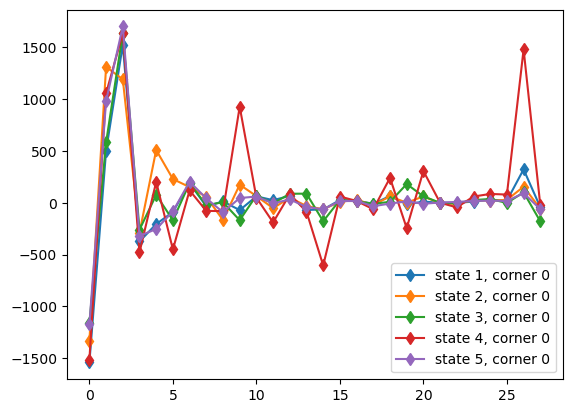

In [454]:
corner = 0 
for state_n in range(1,6):
    plt.plot(np.arange(28), all_opd[state_n][corner], marker='d',  label=f'state {state_n}, corner {corner}')
plt.legend()

This shows that the OPDs for the same state are different for each corner: 

In [ ]:
state_n = 2
#for state_n in range(1,3):
for corner in range(4):
    plt.plot(np.arange(28), all_opd[state_n][corner], marker='d', label=f'state {state_n}, corner {corner}')
plt.legend()


ok : show comparison of all fits, whether stacked or paired, to OPD. 

In [ ]:
butlerRootPath = '/sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo'

output_collection = 'all_states_WEP_direct'

butler = dafButler.Butler(butlerRootPath)
registry = butler.registry

datasetRefs = registry.queryDatasets('donutStampsExtra', collections=[output_collection],
                                     where=f"instrument='LSSTCam' and detector.purpose='WAVEFRONT' ").expanded()
             # where=f"instrument='LSST{butlerInstName}' and detector in (199) ").expanded()
print(len(list(datasetRefs)))
refs = []
for ref in datasetRefs:
    refs.append(ref)
    #print(ref.dataId.visit)

In [ ]:
The `visit` encodes the state, while `raft` tells us which corner this is for. 

In [ ]:
ref.dataId.visit.id

In [ ]:
int(str(ref.dataId.visit.id)[-3:])


In [ ]:
ref.dataId.detector.raft

In [ ]:
# initialize the storage dictionary 
stamps_states = {}
for n in range(1,101):
    stamps_states[n] = {}
    for raft in rafts:
        stamps_states[n][raft] = {}

# store per state ,  per corner ,  the intra/extra  stamps 

for ref in refs: 
    state = int(str(ref.dataId.visit.id)[-3:]) 
    raft = ref.dataId.detector.raft
    
    print(f'Reading {state}  {raft} ')
    
    stampsExtra = butler.get('donutStampsExtra', 
                      dataId=ref.dataId, 
                      collections=[output_collection]
                    )
    stampsIntra = butler.get('donutStampsIntra', 
                      dataId=ref.dataId, 
                      collections=[output_collection]
                    )

    
    stamps_states[state][raft]['donutStampsExtra'] = stampsExtra
    stamps_states[state][raft]['donutStampsIntra'] = stampsIntra


For each state, do just the stacking, since we've shown above that the pipeline zk fit are identical to what I would get. Do I need to start the instrument anew for each detector?  

In [443]:
results_states = {}

for state in range(1,101):
    results_states[state] = {}
    for raft in rafts:
        results_states[state][raft] = {}
        stampsExtra = stamps_states[state][raft]['donutStampsExtra']
        stampsIntra = stamps_states[state][raft]['donutStampsIntra']


        camName = stampsExtra[0].cam_name
        detectorName = stampsExtra[0].detector_name
        
        instrument = getTaskInstrument(
            camName,
            detectorName,
            None,
            #self.config.instConfigFile,
            
        )

    
        estimateZkTieConfig = EstimateZernikesTieConfig()
        estimateZernikesBaseConfig = EstimateZernikesBaseConfig()
        
        
        wfAlgoName = WfAlgorithmName.TIE
        
        algoConfig = {
                    key: val
                    for key, val in estimateZkTieConfig.toDict().items()
                    if key not in estimateZernikesBaseConfig._fields.keys()
                }
        wfAlgoConfig = WfAlgorithmFactory.createWfAlgorithm(wfAlgoName, algoConfig)
            
        
        # Create the wavefront estimator
        wfEst = WfEstimator(
                algoName=wfAlgoName,
            algoConfig=wfAlgoConfig,
            instConfig=instrument,
            jmax=estimateZernikesBaseConfig.maxNollIndex,
            startWithIntrinsic=estimateZernikesBaseConfig.startWithIntrinsic,
            returnWfDev=estimateZernikesBaseConfig.returnWfDev,
            return4Up=estimateZernikesBaseConfig.return4Up,
            units=estimateZernikesBaseConfig.units,
            saveHistory=estimateZernikesBaseConfig.saveHistory,
        )
        
    
        donutExtra = stampsExtra[0]
        donutIntra = stampsIntra[0]
        # the mean defocal offset would be the same for all considered donuts 
        defocalOffset = np.mean(
            [
                donutExtra.defocal_distance,
                donutIntra.defocal_distance,
            ]
        )
        print(state, raft, defocalOffset) 
        wfEst.instrument.defocalOffset = defocalOffset / 1e3  # m -> mm

    
        # stack donuts and estimate as well 
        stackedExtra = stack_donut_wep_im_refactor(stampsExtra,  N =len(stampsExtra), 
                                                  pixel_stack = 'nanmean', use_mask = True)
    
    
        stackedIntra = stack_donut_wep_im_refactor(stampsIntra,  N =len(stampsIntra), 
                                              pixel_stack = 'nanmean', use_mask = True)
    
        zkst = wfEst.estimateZk(stackedExtra['wep_im'], stackedIntra['wep_im'])
        results_states[state][raft]['stacked_zk'] = zkst
        results_states[state][raft]['stackedExtra'] = stackedExtra 
        results_states[state][raft]['stackedIntra'] = stackedIntra 


np.save('results_states_new',results_states)

1 R04 1.5


/tmp/ipykernel_690/280557552.py:69: RuntimeWarning: Mean of empty slice
  donutStackedArray = np.nanmean(stacked_arrays, axis=0)


1 R44 1.5
1 R00 1.5
1 R40 1.5
2 R04 1.5
2 R44 1.5
2 R00 1.5
2 R40 1.5
3 R04 1.5
3 R44 1.5
3 R00 1.5
3 R40 1.5
4 R04 1.5
4 R44 1.5
4 R00 1.5
4 R40 1.5
5 R04 1.5
5 R44 1.5
5 R00 1.5
5 R40 1.5
6 R04 1.5
6 R44 1.5
6 R00 1.5
6 R40 1.5
7 R04 1.5
7 R44 1.5
7 R00 1.5
7 R40 1.5
8 R04 1.5
8 R44 1.5
8 R00 1.5
8 R40 1.5
9 R04 1.5
9 R44 1.5
9 R00 1.5
9 R40 1.5
10 R04 1.5
10 R44 1.5
10 R00 1.5
10 R40 1.5
11 R04 1.5
11 R44 1.5
11 R00 1.5
11 R40 1.5
12 R04 1.5
12 R44 1.5
12 R00 1.5
12 R40 1.5
13 R04 1.5
13 R44 1.5
13 R00 1.5
13 R40 1.5
14 R04 1.5
14 R44 1.5
14 R00 1.5
14 R40 1.5
15 R04 1.5
15 R44 1.5
15 R00 1.5
15 R40 1.5
16 R04 1.5
16 R44 1.5
16 R00 1.5
16 R40 1.5
17 R04 1.5
17 R44 1.5
17 R00 1.5
17 R40 1.5
18 R04 1.5
18 R44 1.5
18 R00 1.5
18 R40 1.5
19 R04 1.5
19 R44 1.5
19 R00 1.5
19 R40 1.5
20 R04 1.5
20 R44 1.5
20 R00 1.5
20 R40 1.5
21 R04 1.5
21 R44 1.5
21 R00 1.5
21 R40 1.5
22 R04 1.5
22 R44 1.5
22 R00 1.5
22 R40 1.5
23 R04 1.5
23 R44 1.5
23 R00 1.5
23 R40 1.5
24 R04 1.5
24 R44 1.5
24 R00 1.5
2

In [446]:

output_collection = 'all_states_WEP_direct'

registry = butler.registry

datasetRefs = registry.queryDatasets('zernikeEstimateRaw', collections=[output_collection],
                                     where=f"instrument='LSSTCam' and detector.purpose='WAVEFRONT' ").expanded()
             # where=f"instrument='LSST{butlerInstName}' and detector in (199) ").expanded()
print(len(list(datasetRefs)))



pipe_zks_states = {}
for state in range(1,101):
    pipe_zks_states[state] = {}
  #  for raft in rafts:
  #     pipe_zks_states[state][raft] = {} 

for ref in datasetRefs:

    state = int(str(ref.dataId.visit.id)[-3:]) 
    raft = ref.dataId.detector.raft
    
    #print(f'Reading {state}  {raft} ')


    #refs.append(ref)
    #print(ref.dataId)
    zks = butler.get('zernikeEstimateRaw', 
                      dataId=ref.dataId, 
                      collections=[output_collection]
                    )
    pipe_zks_states[state][raft] = zks
    
    #zks[ref.dataId.detector.raft] =  zk

400


In [520]:
registry.queryDatasetTypes()

[DatasetType('camera', {instrument}, Camera, isCalibration=True),
 DatasetType('transmission_sensor', {instrument, detector}, TransmissionCurve, isCalibration=True),
 DatasetType('raw', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure),
 DatasetType('isr_config', {}, Config),
 DatasetType('isr_log', {band, instrument, day_obs, detector, group, physical_filter, exposure}, ButlerLogRecords),
 DatasetType('isr_metadata', {band, instrument, day_obs, detector, group, physical_filter, exposure}, TaskMetadata),
 DatasetType('postISRCCD', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure),
 DatasetType('packages', {}, Packages),
 DatasetType('calcZernikesTask_config', {}, Config),
 DatasetType('cutOutDonutsCwfsTask_config', {}, Config),
 DatasetType('generateDonutDirectDetectTask_config', {}, Config),
 DatasetType('donutCatalog', {band, instrument, day_obs, detector, physical_filter, visit}, DataFrame),
 DatasetType('generateDonu

In [521]:
pipe_zks_states_avg = {}
for state in range(1,101):
    pipe_zks_states_avg[state] = {}
  #  for raft in rafts:
  #     pipe_zks_states[state][raft] = {} 

for ref in datasetRefs:

    state = int(str(ref.dataId.visit.id)[-3:]) 
    raft = ref.dataId.detector.raft
    
    #print(f'Reading {state}  {raft} ')


    #refs.append(ref)
    #print(ref.dataId)
    zks = butler.get('zernikeEstimateAvg', 
                      dataId=ref.dataId, 
                      collections=[output_collection]
                    )
    pipe_zks_states_avg[state][raft] = zks

In [522]:
pipe_zks_states_avg[state][raft]

array([-3.34033137e-01,  7.25357193e-01, -5.19261029e-01,  3.07563010e-01,
        5.14167775e-02,  2.18194102e-01, -1.55380964e-01,  3.66641850e-04,
        1.48544869e-02,  8.13515115e-02,  6.20790111e-02, -2.31683897e-01,
       -1.29826889e-02, -4.70026958e-02,  4.27006035e-02, -2.94970205e-02,
        1.11492736e-01,  1.09987170e-01, -1.20441360e-02])

In [ ]:
Check how to get the raw zks for a particular state / detector : 

In [462]:
len(all_opd[state][0])

28

opd is stored in the header from 1 to 28,  so to plot zk4:22,  need to select\

        opd[0] : zk1
        opd[1] : zk2
        opd[2] : zk3
        opd[3] : zk4
        ...
        opd[21]: zk22

and we know that in selection we don't include the last element, so  to get zk4:22 (19 elements)  we need to select
   
        opd[3:22]  


      


In [468]:
len(np.arange(4,23))

19

In [507]:
len(all_opd)

9

In [465]:
len(all_opd[state][0][3:22])

19

In [472]:

opd_raft_to_id = {'R00':0, 'R04':1, 'R40':2, 'R44':3}  



In [474]:
rafts

['R04', 'R44', 'R00', 'R40']

In [529]:
np.mean(pipe_raw_zks, axis=0)

array([-0.47044355,  1.21252654, -0.04717373,  0.13427638,  0.12860872,
        0.23751774,  0.1511789 , -0.02475406,  0.04979431,  0.08812586,
        0.15038509, -0.37561139, -0.03105272,  0.00962781,  0.1071275 ,
        0.03189038, -0.21993305,  0.23041494, -0.01991156])

In [554]:
opdId = opd_raft_to_id[raft] 


avg_zk = np.mean(pipe_zks_states[state][raft], axis=0)

stacked_zk = results_states[state][raft]['stacked_zk']

opd_zk = 0.001*np.array(all_opd[state][opdId][3:22])

In [555]:
#np.square?

In [556]:
rms_diff_stack = np.sqrt(np.mean(np.square(stacked_zk-opd_zk)))
rms_diff_avg =  np.sqrt(np.mean(np.square(avg_zk-opd_zk)))

In [557]:
print(rms_diff_stack)


0.18770593252694034


In [558]:
print(rms_diff_avg)

0.13189458608912175


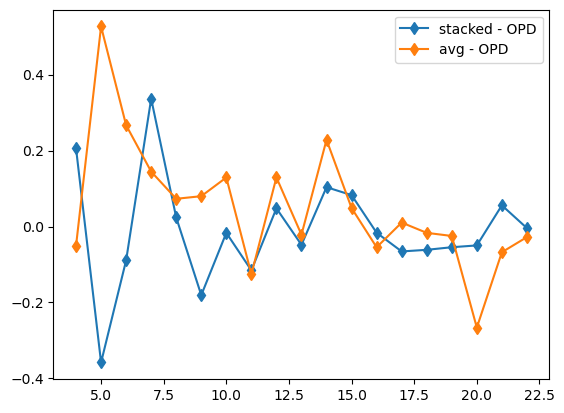

In [548]:
plt.plot(np.arange(4,23), stacked_zk-opd_zk, marker='d', label='stacked - OPD')
plt.plot(np.arange(4,23), avg_zk-opd_zk, marker='d', label='avg - OPD')
plt.legend()

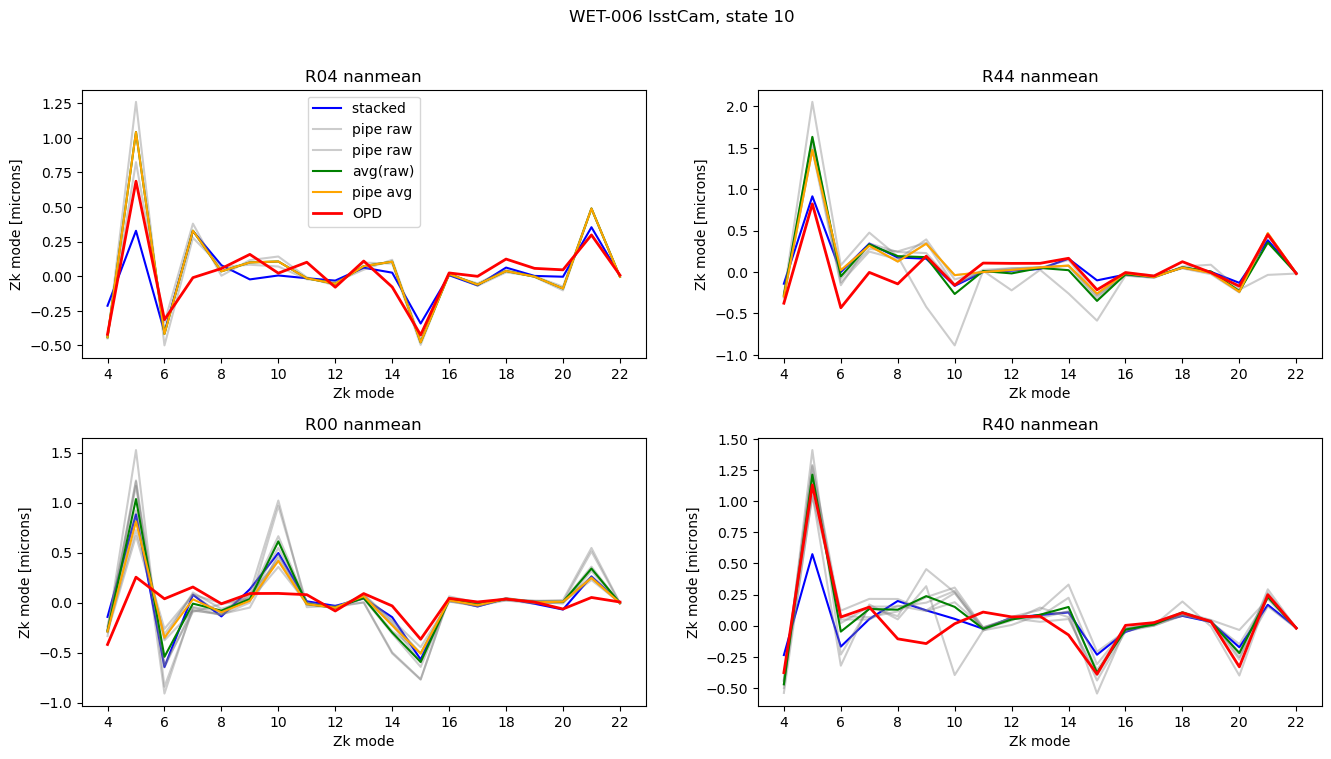

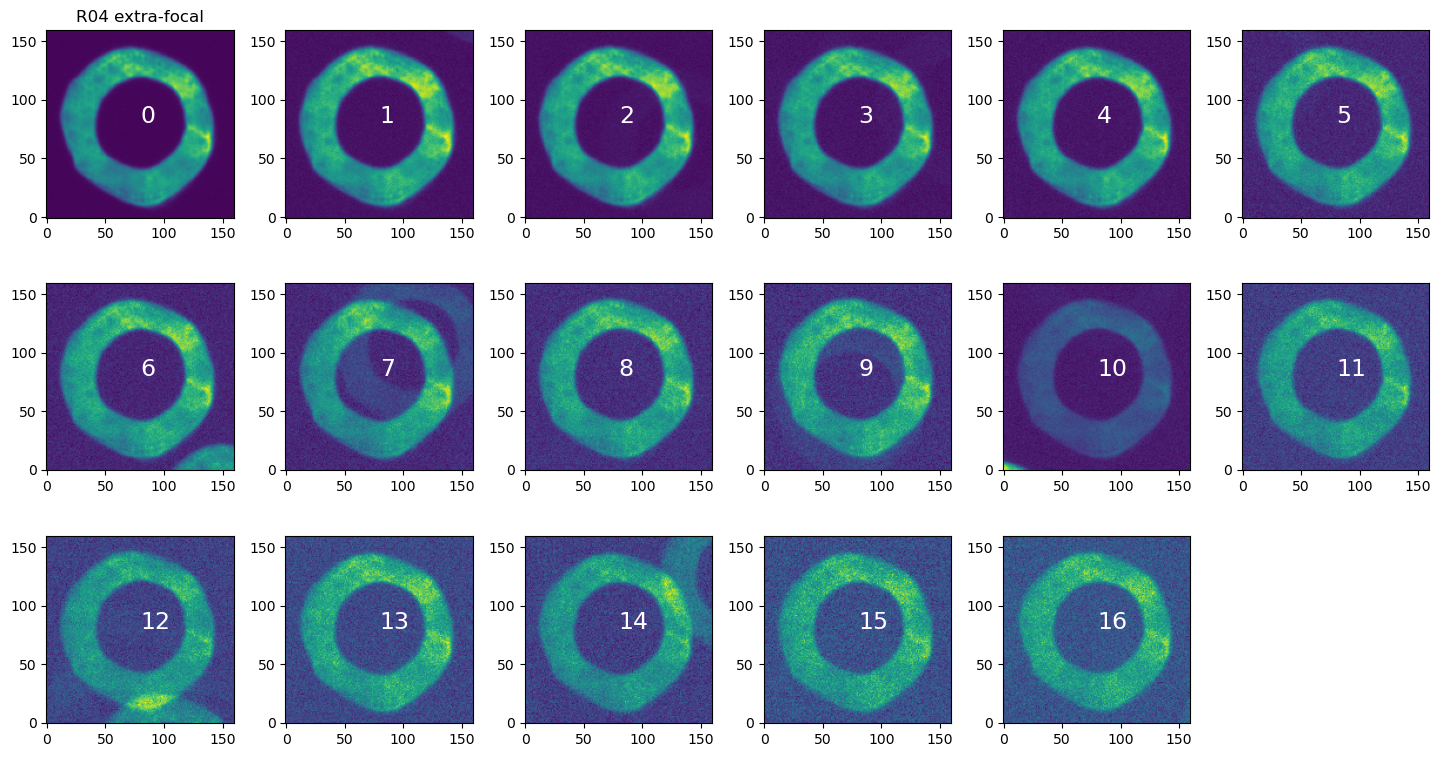

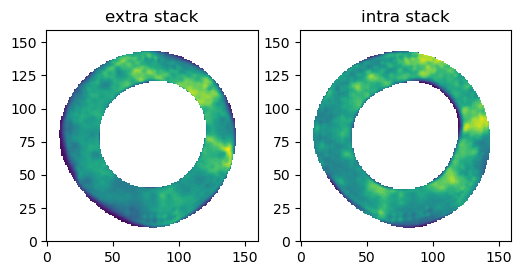

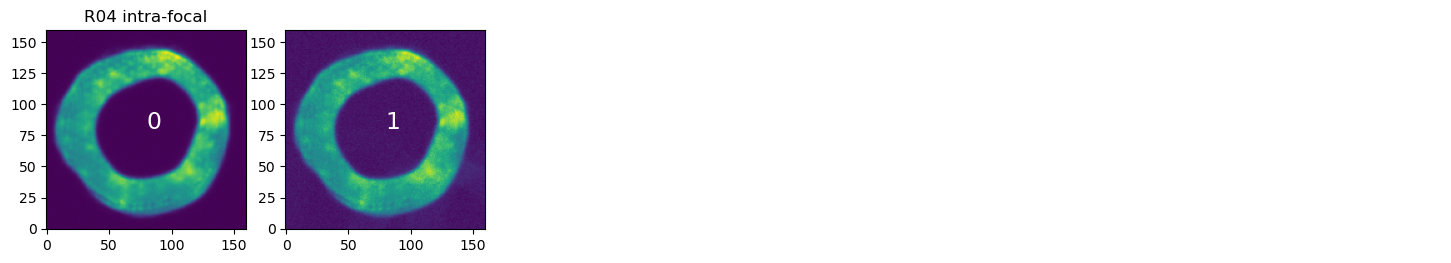

In [535]:
# plot the results in the same order as the 
# sensor position in CCS 

#    R04                 R44
# O-------           ----------O        /\ +y (CCS)
# |  SW1 |           |    |    |        |
# |------|           |SW0 | SW1|        |
# |  SW0 |           |    |    |        |
# -------O           O----------        _
#                                   +z (.) -----> +x
#      R00                  R40
# ------------O          O-------
# |     |     |          |  SW0 |
# | SW1 | SW0 |          |------|
# |     |     |          |  SW1 |
# O------------          -------O

opd_id_rafts = ['R00', 'R04', 'R40', 'R44'] 
rafts = ['R04', 'R44', 'R00','R40']
state=10
#for state in range(1,10):

fig,axs = plt.subplots(2,2,figsize=(16,8))
ax = np.ravel(axs)
i=0
# this plots the two sets of  results  
for raft in rafts:
    
    ax[i].set_title(raft + ' nanmean')
    #for results,col,ls, label in zip([results_0, results_1], ['blue' , 'green'], ['--','-.'],
    #                                ['keep zeros', 'replace as nans']):
    
    ax[i].plot(np.arange(4,23), results_states[state][raft]['stacked_zk'], label=f'stacked ', c='blue')#replace as nans {raft}')
    # plot raw zks from only one set of stacking results 
    pipe_raw_zks =  pipe_zks_states[state][raft]
    for j in range(len(pipe_raw_zks)):
            ax[i].plot(np.arange(4,23), pipe_raw_zks[j],alpha=0.4 , 
                    c='grey', label='pipe raw')
    # average out zks 
    ax[i].plot(np.arange(4,23), np.mean(pipe_raw_zks, axis=0), label='avg(raw)',c='green')

    # plot average Zks
    zkavg = pipe_zks_states_avg[state][raft]
    ax[i].plot(np.arange(4,23), zkavg, label='pipe avg', c='orange')
    
    # plot OPD
    opdId = opd_raft_to_id[raft] 
    ax[i].plot(np.arange(4,23), 0.001*np.array(all_opd[state][opdId][3:22]), label='OPD', c='red', lw=2)
    
#bbox_to_anchor=[1.0,0.8])
    ax[i].set_ylabel('Zk mode [microns]')
    ax[i].set_xlabel('Zk mode')
    ax[i].set_xticks([4,6,8,10,12,14,16,18,20,22])

    i+=1
ax[0].legend()

fig.subplots_adjust(hspace=0.3)
fig.suptitle(f'WET-006 lsstCam, state {state}')


# plot the donut stamps for a particular corner 
raft = 'R04'
plot_donut_stamps(stamps_states[state][raft]['donutStampsExtra'] , text='R04 extra-focal')
fig,ax = plt.subplots(1,2,figsize=(6,3))

ax[0].imshow(results_states[state][raft]['stackedExtra']['donutStackedArray'], origin='lower')
ax[1].imshow(results_states[state][raft]['stackedIntra']['donutStackedArray'], origin='lower')
ax[0].set_title('extra stack')
ax[1].set_title('intra stack')

plot_donut_stamps(stamps_states[state][raft]['donutStampsIntra'] , text='R04 intra-focal')


# plot the "stacked" donut pair per corner 
#results_states[state][raft]['stackedExtra']


Text(0.5, 0.98, 'WET-006 lsstCam, state 10')

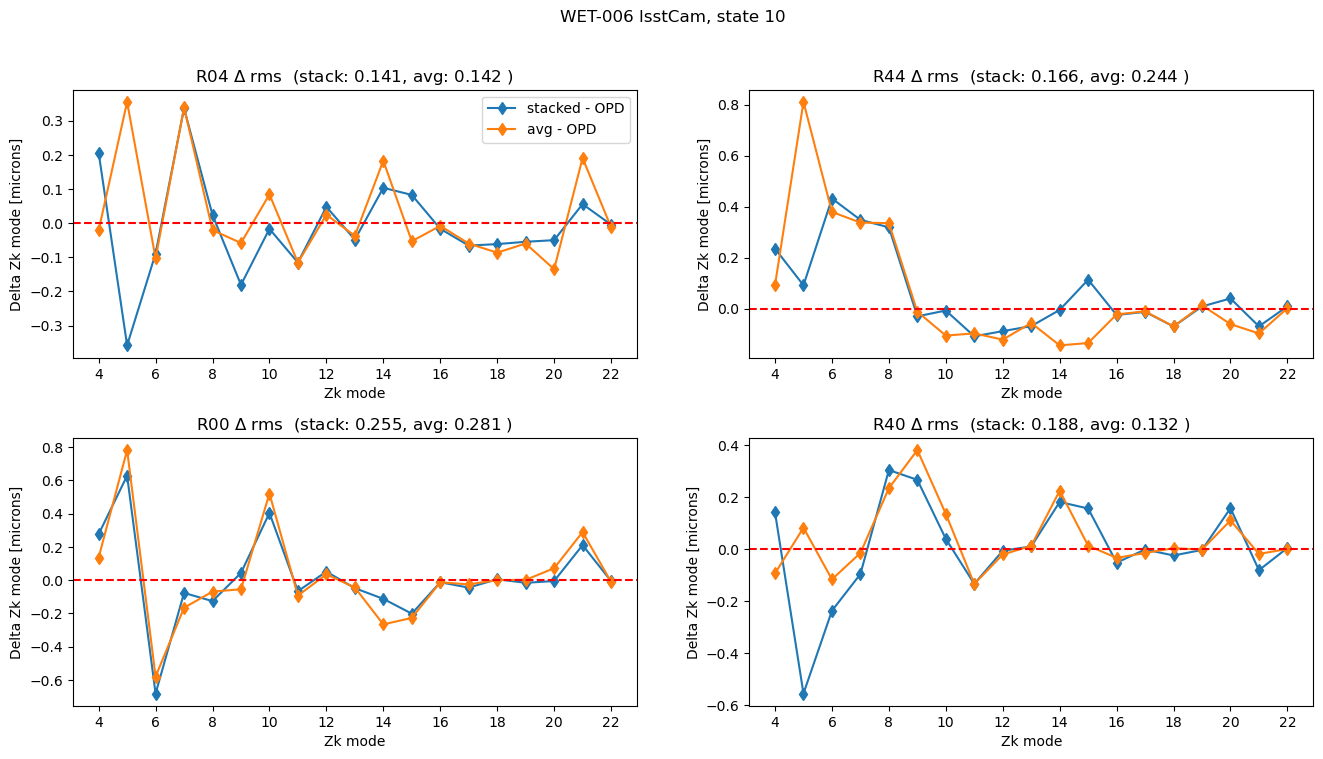

In [568]:
fig,axs = plt.subplots(2,2,figsize=(16,8))
ax = np.ravel(axs)
i=0
# this plots the two sets of  results  
for raft in rafts:
    opdId = opd_raft_to_id[raft] 
    avg_zk = np.mean(pipe_zks_states[state][raft], axis=0)
    stacked_zk = results_states[state][raft]['stacked_zk']
    opd_zk = 0.001*np.array(all_opd[state][opdId][3:22])

    rms_diff_stack = np.sqrt(np.mean(np.square(stacked_zk-opd_zk)))
    rms_diff_avg =  np.sqrt(np.mean(np.square(avg_zk-opd_zk)))
    ax[i].set_title(f'{raft} '+r'$\Delta$ rms'+f'  (stack: {rms_diff_stack:.3f}, ' + f'avg: {rms_diff_avg:.3f} )')
    ax[i].plot(np.arange(4,23), stacked_zk-opd_zk, marker='d', label='stacked - OPD')
    ax[i].plot(np.arange(4,23), avg_zk-opd_zk, marker='d', label='avg - OPD')
    ax[i].set_ylabel('Delta Zk mode [microns]')
    ax[i].set_xlabel('Zk mode')
    ax[i].set_xticks([4,6,8,10,12,14,16,18,20,22])
    ax[i].axhline(0,ls='--', c='red')
    i+=1
ax[0].legend()

fig.subplots_adjust(hspace=0.3)
fig.suptitle(f'WET-006 lsstCam, state {state}')

In [525]:
state=10
raft = 'R40'
pipe_zks_states_avg[state][raft]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan])

So interestingly for R40 the averaged donuts are `nan` (!)  Why?? Since that's the case,  need to manually calculate the mean of raw zks: 

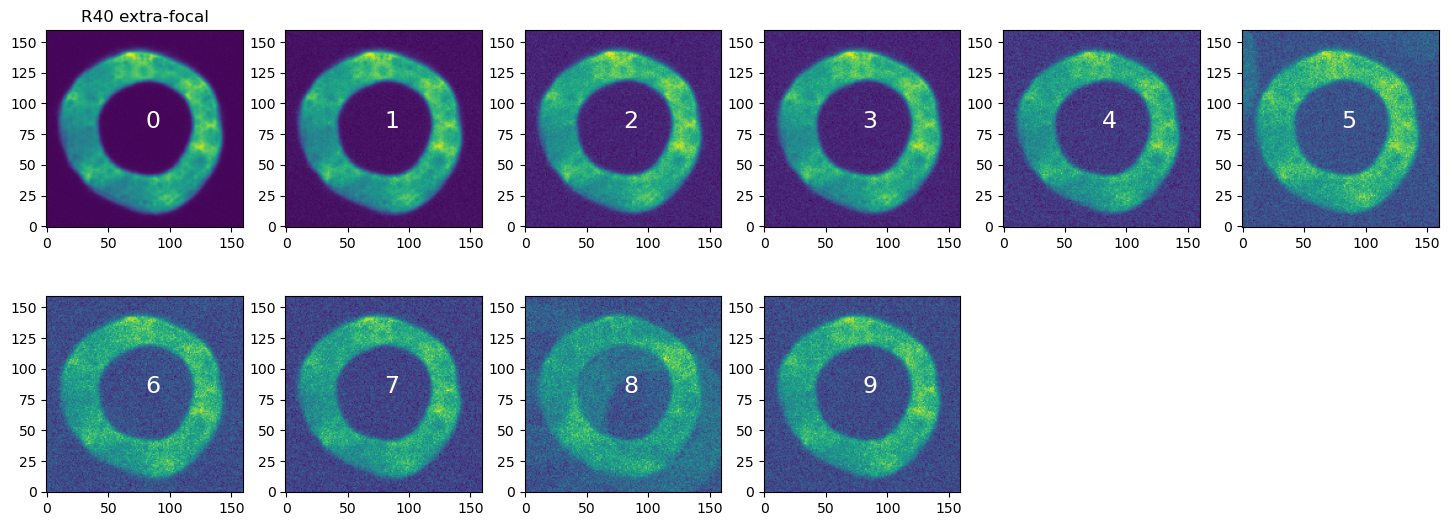

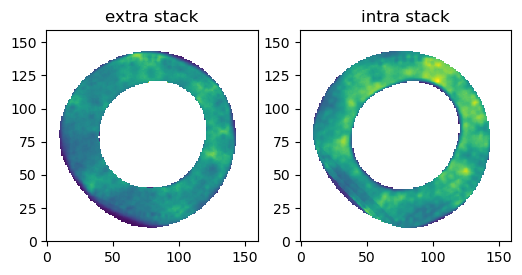

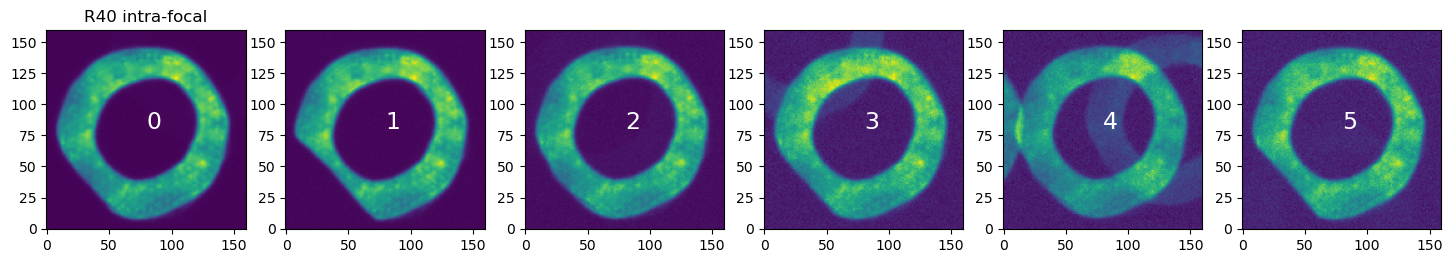

In [527]:
# plot the donut stamps for a particular corner 
raft = 'R40'
plot_donut_stamps(stamps_states[state][raft]['donutStampsExtra'] , text=f'{raft} extra-focal')
fig,ax = plt.subplots(1,2,figsize=(6,3))

ax[0].imshow(results_states[state][raft]['stackedExtra']['donutStackedArray'], origin='lower')
ax[1].imshow(results_states[state][raft]['stackedIntra']['donutStackedArray'], origin='lower')
ax[0].set_title('extra stack')
ax[1].set_title('intra stack')

plot_donut_stamps(stamps_states[state][raft]['donutStampsIntra'] , text=f'{raft} intra-focal')


The quality of the "stack" could be affected by the constituent donuts... Eg how far away from the used mask the `fieldX`  or `fieldY` are... Plit the input fieldX, fieldY of the raw donuts, and the  field position of the created "median" donut: 

In [518]:

for i in range(len(hdul)):
    print(i, hdul[i].header['THX'], hdul[i].header['THY'])

0 -1.1897 -1.1897
1 -1.1897 1.1897
2 1.1897 -1.1897
3 1.1897 1.1897


Text(0.05, 0.5, 'fieldY [deg]')

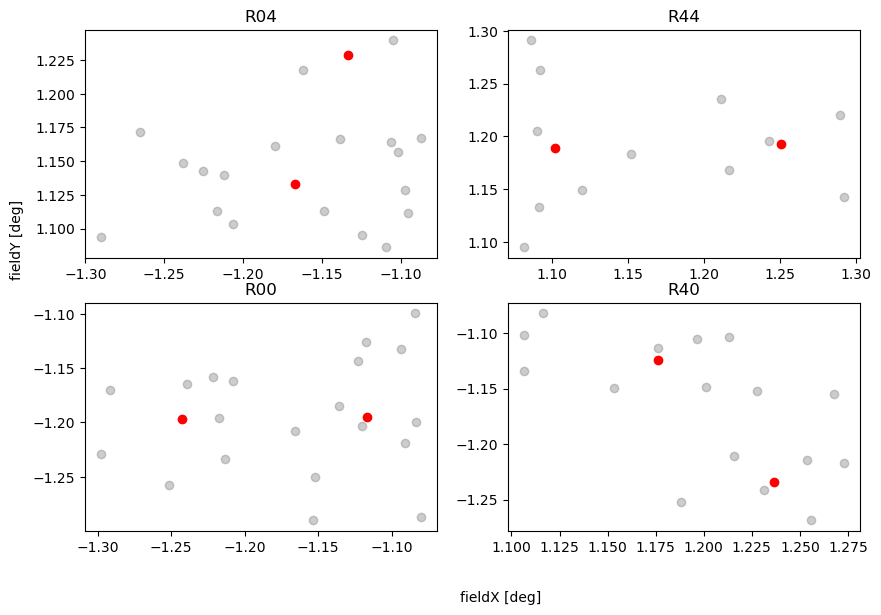

In [517]:



    
    
fig,  axs = plt.subplots(2,2, figsize=(10,6.5)) 
ax = np.ravel(axs)
i=0
for raft in rafts: #  'R04'
    ax[i].set_title(raft)
    
    for half in ['Ex', 'In']:
        ax[i].scatter(results_states[state][raft][f'stacked{half}tra']['fieldX']  , results_states[state][raft][f'stacked{half}tra']['fieldY'], c='grey', alpha=0.4  )
        ax[i].scatter(results_states[state][raft][f'stacked{half}tra']['fieldXmean'], results_states[state][raft][f'stacked{half}tra']['fieldYmean'], c='red')
    
    #ax[i].set_xlabel('field X [deg]')
    #ax[i].set_ylabel('field Y [deg]')
    i+=1

fig.text(0.5,0,'fieldX [deg]')
fig.text(0.05,0.5,'fieldY [deg]', rotation=90)

calculate the rms difference per detector and plot for all states: 

In [576]:
rmss = {}
for raft in rafts:
    rmss[raft] = {'rms_diff_stack':[], 'rms_diff_avg':[]}

for state in range(1,101):
    for raft in rafts:
        opdId = opd_raft_to_id[raft] 
        avg_zk = np.mean(pipe_zks_states[state][raft], axis=0)
        stacked_zk = results_states[state][raft]['stacked_zk']

        rms_diff_stack = np.sqrt(np.mean(np.square(stacked_zk-opd_zk)))
        rms_diff_avg =  np.sqrt(np.mean(np.square(avg_zk-opd_zk)))
         
        rmss[raft]['rms_diff_stack'].append(rms_diff_stack)
        rmss[raft]['rms_diff_avg'].append(rms_diff_avg)



Text(0.06, 0.5, 'RMS ($\\Delta$(zk-opd) ) ')

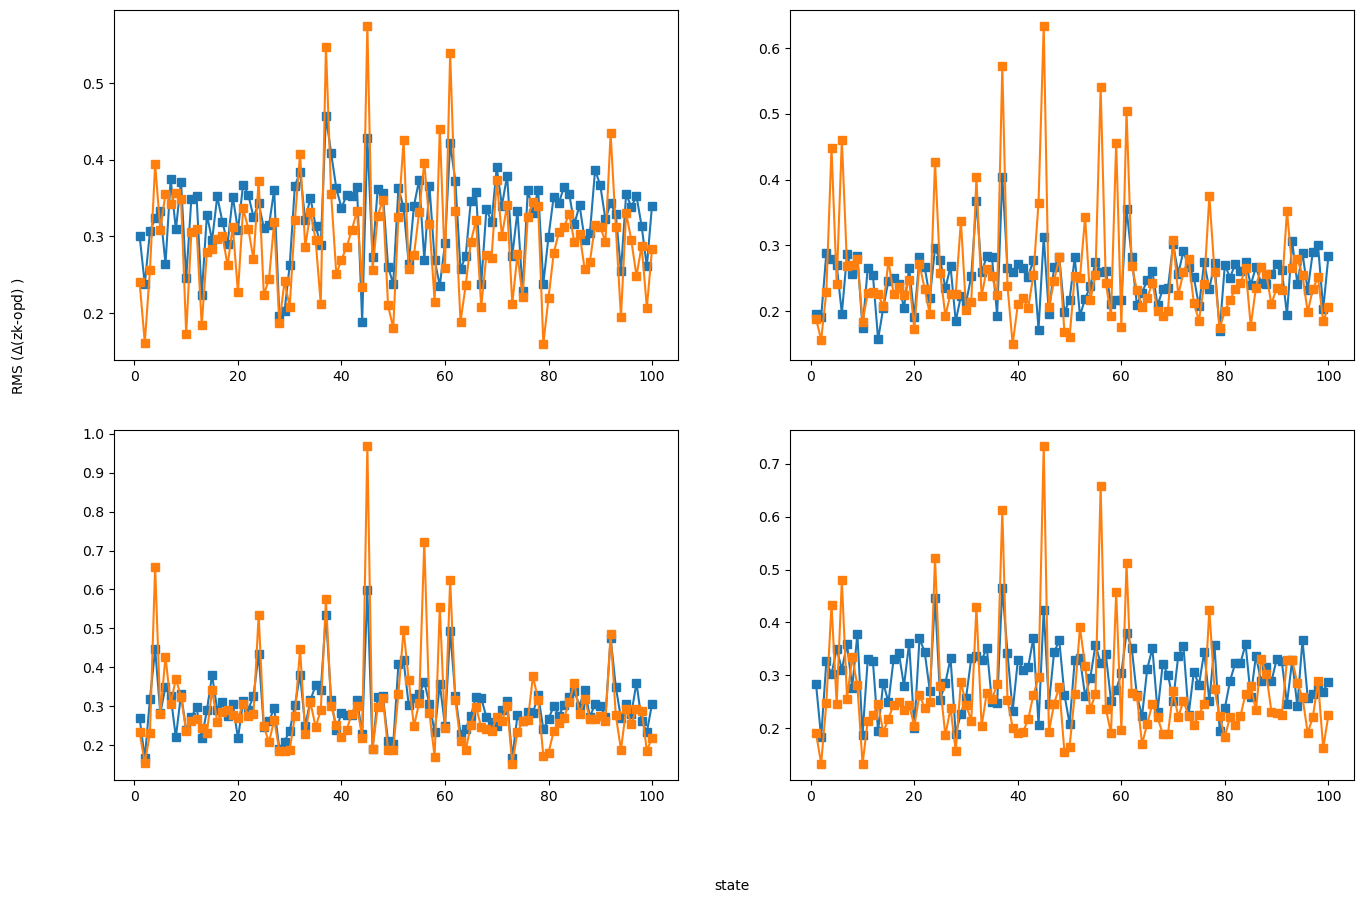

In [583]:
fig,axs = plt.subplots(2,2,figsize=(16,10))
ax = np.ravel(axs)
i=0
for raft in rafts:
    ax[i].plot(np.arange(1,101), rmss[raft]['rms_diff_stack'], marker='s', label='stacked')
    ax[i].plot(np.arange(1,101), rmss[raft]['rms_diff_avg'], marker='s', label='averaged')
    i+=1

fig.text(0.5,0,'state')
fig.text(0.06,0.5,r'RMS ($\Delta$(zk-opd) ) ', rotation=90)

Based on that I don't see any prevailing trends between stacking vs using the pipeline average (pairing) 